##### XGB-Stepregression   
##20220409sym编写 
### 简介：  
使用逐步回归的方法提取最重要的特征相互作用
### 更新记录：  
V2，20221221sym更新，  
V2.1,20240117sym更新，加入yrealtestpred，假如要预测完全数据外的情况，用这个程序
V2.2，20240408sym更改，加入pred的std，并可以任意指定全集中的测试集，根据化学假的需求

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import gc
import os
from pathlib import Path
c_time = time.strftime("%Y%m%d_%H%M%S", time.localtime())
c_time_m = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())


In [2]:
# 参数
# ======== System Setup ========
Version = 'V2.2sym'
EPOCH = 160
CORE_NUM = 32
# 确保EPOCH*REPEAT_ROUND是CORE_NUM的整数倍
TRAIN_TEST_SPLIT = 0.85
# ======== Fit Data Input ========
S_N = 43
F_N = 62
INPUT_X = 'Features_'+str(S_N)+'_'+str(F_N)+'.csv'
INPUT_Y = 'Values_True_'+str(S_N)+'.csv'
INPUT_TITLE = 'Title_'+str(F_N)+'.csv'
INPUT_SMILES = 'Smiles_'+str(S_N)+'.csv'
RECORD_NAME = 'Record_Stepreg_'+Version+'_'+c_time+'.txt'

X = np.loadtxt(INPUT_X, delimiter=',')
y = np.loadtxt(INPUT_Y)
title = np.loadtxt(INPUT_TITLE, dtype=str, delimiter=',', comments='!')
#是否设定第一特征
KNOW_inifeat=False
inifeat=[37]
# 记得减一
#F_N-1为全部特征都筛选
Stepfeatnum=5

# List of test set indices provided by the user
test_indices = [5,9,23,35]  # 对应是Full的matrix是刚刚好（有title的特征和标签值的Full）
test_indices = [i - 2 for i in test_indices]
test_mask = np.zeros(len(y), dtype=bool)
test_mask[test_indices] = True
X_train = X[~test_mask]
y_train = y[~test_mask]
Xrealtest = X[test_mask]
yrealtest = y[test_mask]
X=X_train
y=y_train


In [3]:
len(y)

39

In [4]:
yrealtest

array([6.3 , 6.95, 6.89, 7.2 ])

In [5]:
import shap
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn import model_selection
import joblib
from multiprocessing import Pool

In [6]:
DIR = 'Stepreg-XGB_'+Version+'_'+c_time
os.mkdir(DIR)
RECORD_NAME = Path('.', DIR, RECORD_NAME)
f1 = open(RECORD_NAME, 'w')
f1.write('Record of XGB-Stepregression '+Version+'\n\n')
f1.write('Generation time: '+time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())+'\n\n\n')
f1.write('Inputfiles are: '+INPUT_X+'+'+INPUT_Y+'+'+INPUT_TITLE+'+'+'\n\n\n')
f1.write('EPOCH= '+str(EPOCH)+' CORENUM= '+str(CORE_NUM)+INPUT_X+' splitratio= '+str(round(TRAIN_TEST_SPLIT,3))+'\n\n\n')
f1.write('test list see Feature matrix '+str(test_indices)+'\n\n\n')

save_nameX = 'Feature_X_train_'+str(len(y))+'_'+str(F_N)+'_'+c_time+'.csv'
save_nameX = Path('.', DIR, save_nameX)
np.savetxt(save_nameX, X_train, fmt='%s', delimiter=',')
save_nameX = 'Feature_X_realtest_'+str(len(yrealtest))+'_'+str(F_N)+'_'+c_time+'.csv'
save_nameX = Path('.', DIR, save_nameX)
np.savetxt(save_nameX, Xrealtest, fmt='%s', delimiter=',')
save_nameX = 'Value_y_train_'+str(len(y))+'_'+c_time+'.csv'
save_nameX = Path('.', DIR, save_nameX)
np.savetxt(save_nameX, y_train, fmt='%s', delimiter=',')
save_nameX = 'Value_y_realtest_'+str(len(yrealtest))+'_'+c_time+'.csv'
save_nameX = Path('.', DIR, save_nameX)
np.savetxt(save_nameX, yrealtest, fmt='%s', delimiter=',')

In [7]:
clf = XGBRegressor(n_estimators=350, learning_rate=0.03, max_depth=8, verbosity=0, booster='gbtree', 
                   reg_alpha=np.exp(-3), reg_lambda=np.exp(-3), gamma=np.exp(-5), 
                   subsample=0.5, objective= 'reg:squarederror', n_jobs=1)
paras = clf.get_params()
mse_list = []
mae_list = []
r2_list = []

In [8]:
def XGB_Fit(X, y, X_train, y_train, X_test, y_test, paras):
    clf_new = XGBRegressor()
    for k, v in paras.items():
        clf_new.set_params(**{k: v})
    # print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
    # 拟合模型
    clf_new.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=150, verbose=False)
    # 计算损失
    y_pred = clf_new.predict(X_test)
#     mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
#     r2 = r2_score(y_test, y_pred)
#     shap_values = shap.TreeExplainer(clf_new).shap_values(X)
#     s = np.mean(clf_new.predict(X))-np.mean(y_train)
#     s2 = np.mean(clf_new.predict(X))-np.mean(y)
#     print(np.sum(shap_values), s, s2)
#     # f_i = clf_new.feature_importances_
#      temp = [mse, mae, r2, shap_values, s, s2]
    temp = [mse]
#     print('   MSE: %.5f' % mse, '  MAE: %.5f' % mae, '  R^2: %.5f' % r2)
    del y_pred
    return (temp, 'None')
def flatten(li):
    return sum(([x] if not isinstance(x, list) else flatten(x) for x in li), [])


In [9]:
def poolfit(TRAIN_TEST_SPLIT,EPOCH,CORE_NUM,X, y, paras):
    r_l = []
    point = round(X.shape[0]*TRAIN_TEST_SPLIT)
    for _ in range(int(EPOCH/CORE_NUM)):
        print('Round', CORE_NUM*(_)+1, 'Begin:')
        pool = Pool(CORE_NUM)
        for __ in range(CORE_NUM):
            permutation = np.random.permutation(y.shape[0])
            train_idx = permutation[:point]
            test_idx = permutation[point:]
            X_train = X[train_idx, :]
            y_train = y[train_idx]
            X_test = X[test_idx, :]
            y_test = y[test_idx]
            r = pool.apply_async(XGB_Fit, args=(X, y, X_train, y_train, X_test, y_test, paras,))
            r_l.append(r)
        pool.close()
        pool.join()
    mse_list=[]
#     mae_list=[]
#     r2_list=[]
#     shap_m = np.zeros((S_N, F_Ntemp))
    for i in range(len(r_l)):
        r = r_l[i]
        results = r.get()
        temp = results[0]
        mse = temp[0]
#         mae = temp[1]
#         r2 = temp[2]
        mse_list.append(mse)
#         mae_list.append(mae)
#         r2_list.append(r2)

    mse1=np.mean(mse_list)
#     mae1=np.mean(mae_list)
#     r21=np.mean(r2_list)
#     temp = [mse1, mae1, r21]
    temp = [mse1]
    return temp

Round 0
Round 1 Begin:
Round 33 Begin:
Round 65 Begin:
Round 97 Begin:
Round 129 Begin:
Round 1
Round 1 Begin:
Round 33 Begin:
Round 65 Begin:
Round 97 Begin:
Round 129 Begin:
Round 2
Round 1 Begin:
Round 33 Begin:
Round 65 Begin:
Round 97 Begin:
Round 129 Begin:
Round 3
Round 1 Begin:
Round 33 Begin:
Round 65 Begin:
Round 97 Begin:
Round 129 Begin:
Round 4
Round 1 Begin:
Round 33 Begin:
Round 65 Begin:
Round 97 Begin:
Round 129 Begin:
Round 5
Round 1 Begin:
Round 33 Begin:
Round 65 Begin:
Round 97 Begin:
Round 129 Begin:
Round 6
Round 1 Begin:
Round 33 Begin:
Round 65 Begin:
Round 97 Begin:
Round 129 Begin:
Round 7
Round 1 Begin:
Round 33 Begin:
Round 65 Begin:
Round 97 Begin:
Round 129 Begin:
Round 8
Round 1 Begin:
Round 33 Begin:
Round 65 Begin:
Round 97 Begin:
Round 129 Begin:
Round 9
Round 1 Begin:
Round 33 Begin:
Round 65 Begin:
Round 97 Begin:
Round 129 Begin:
Round 10
Round 1 Begin:
Round 33 Begin:
Round 65 Begin:
Round 97 Begin:
Round 129 Begin:
Round 11
Round 1 Begin:
Round 3

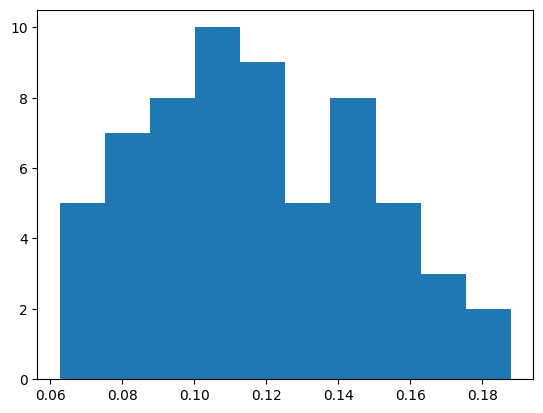

In [10]:
#在这里mse越小越好
if KNOW_inifeat == False:
    perflist1=[]
    for j in range (F_N):  
        print('Round',j)
        inifeat=title[j]
        inifeatindex=np.where(title==inifeat)[0][0]
        featlist=[]
        featlist.append(inifeatindex)
        Xtemp=X[:,featlist]
        perf=poolfit(TRAIN_TEST_SPLIT,EPOCH,CORE_NUM,Xtemp, y, paras)
        perflist1.append(perf[0])    
    inifeat=np.where(perflist1==np.min(perflist1))
    print(inifeat)
    print(np.min(perflist1))
    print(perflist1)
    print(np.argsort(perflist1))
    perflistt=np.argsort(perflist1)
    for _ in range(10):
        print(title[perflistt[_]])
#画分布图
    n, bins, patches = plt.hist(perflist1)
    plt.show()
else:
    print('Already given first feature is ',title[inifeat],inifeat)

In [11]:
title[inifeat]

array(['buriedH5'], dtype='<U48')

In [12]:
inifeatindex=np.where(title==title[inifeat])[0][0]
print('first feature is ',inifeatindex)
featlist=[]
bestfeatlist=[]
mseind=[]
mselist=[]
for i in range(Stepfeatnum):#for i in range(F_N-1):
    perflist=np.linspace(0,0,len(title))
    print('Now we have ', i+1, 'Features.Begin regression!')
    if i ==0:       
        featlist.append(inifeatindex)
        print(featlist)
        Xtemp=X[:,featlist]
        print(Xtemp[0])
        perf=poolfit(TRAIN_TEST_SPLIT,EPOCH,CORE_NUM,Xtemp, y, paras)
        perflist=perf[0]
        bestfeatlist=featlist
        print('Round 1_'+str(title[bestfeatlist])+'_'+str(perflist)+'\n')
        f1.write('Round 1_'+str(title[bestfeatlist])+'_'+str(perflist)+'\n')
    else:
        for j in range (F_N):     
            featlist=bestfeatlist.copy()
            print('j=',j)
            if j in bestfeatlist:
                print('Already selected feature!')
            else:                   
                featlist.append(j)
                print('featlist=',featlist)
                Xtemp=X[:,featlist]
                print(Xtemp[0])
                perf=poolfit(TRAIN_TEST_SPLIT,EPOCH,CORE_NUM,Xtemp, y, paras)
                perflist[j]=perf[0]
                print('perflist=',perflist)  
        max2 = np.sort(perflist)[i]
        mseind = np.argsort(perflist)[i]
        print('This feature is',mseind)
        print('best performance is',max2)
        bestfeatlist.append(mseind)
        print('bestfeatlist=',bestfeatlist)
        print(('Round '+str(len(title[bestfeatlist]))+'_'+str(title[bestfeatlist])+'_'+str(round(max2,4))+'\n'))
        f1.write('Round '+str(len(title[bestfeatlist]))+'_'+str(title[bestfeatlist])+'_'+str(round(max2,4))+'\n')
        mselist.append(max2)
        print(mselist)
f1.close()

first feature is  4
Now we have  1 Features.Begin regression!
[4]
[0.63218063]
Round 1 Begin:
Round 33 Begin:
Round 65 Begin:
Round 97 Begin:
Round 129 Begin:
Round 1_['buriedH5']_0.061489317917775996

Now we have  2 Features.Begin regression!
j= 0
featlist= [4, 0]
[0.63218063 0.68425037]
Round 1 Begin:
Round 33 Begin:
Round 65 Begin:
Round 97 Begin:
Round 129 Begin:
perflist= [0.06298786 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 1
f

Round 33 Begin:
Round 65 Begin:
Round 97 Begin:
Round 129 Begin:
perflist= [0.06298786 0.06437479 0.05504235 0.05016899 0.         0.06408542
 0.05621688 0.06671476 0.06016126 0.06432764 0.06739401 0.0546189
 0.05855084 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 13
featlist= [4, 13]
[0.63218063 9.66973286]
Round 1 Begin:
Round 33 Begin:
Round 65 Begin:
Round 97 Begin:
Round 129 Begin:
perflist= [0.06298786 0.06437479 0.05504235 0.05016899 0.         0.06408542
 0.05621688 0.06671476 0.06016126 0.06432764 0.06739401 0.0546189
 0.05855084 0.06353795 0.

Round 33 Begin:
Round 65 Begin:
Round 97 Begin:
Round 129 Begin:
perflist= [0.06298786 0.06437479 0.05504235 0.05016899 0.         0.06408542
 0.05621688 0.06671476 0.06016126 0.06432764 0.06739401 0.0546189
 0.05855084 0.06353795 0.05666994 0.05595593 0.05658171 0.07125845
 0.06071831 0.04664892 0.05378438 0.05731771 0.05064757 0.04957333
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 24
featlist= [4, 24]
[  0.63218063 -13.394     ]
Round 1 Begin:
Round 33 Begin:
Round 65 Begin:
Round 97 Begin:
Round 129 Begin:
perflist= [0.06298786 0.06437479 0.05504235 0.05016899 0.         0.06408542
 0.05621688 0.06671476 0.06016126 0.06432764 0.06739401 0.0546189
 0.05

Round 33 Begin:
Round 65 Begin:
Round 97 Begin:
Round 129 Begin:
perflist= [0.06298786 0.06437479 0.05504235 0.05016899 0.         0.06408542
 0.05621688 0.06671476 0.06016126 0.06432764 0.06739401 0.0546189
 0.05855084 0.06353795 0.05666994 0.05595593 0.05658171 0.07125845
 0.06071831 0.04664892 0.05378438 0.05731771 0.05064757 0.04957333
 0.04836615 0.05826276 0.05997723 0.0513728  0.05864682 0.04808323
 0.0451475  0.06463712 0.05565918 0.05599301 0.05131318 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 35
featlist= [4, 35]
[0.63218063 8.5617    ]
Round 1 Begin:
Round 33 Begin:
Round 65 Begin:
Round 97 Begin:
Round 129 Begin:
perflist= [0.06298786 0.06437479 0.05504235 0.05016899 0.         0.06408542
 0.05621688 0.06671476 0.06016126 0.06432764 0.06739401 0.0546189
 

Round 33 Begin:
Round 65 Begin:
Round 97 Begin:
Round 129 Begin:
perflist= [0.06298786 0.06437479 0.05504235 0.05016899 0.         0.06408542
 0.05621688 0.06671476 0.06016126 0.06432764 0.06739401 0.0546189
 0.05855084 0.06353795 0.05666994 0.05595593 0.05658171 0.07125845
 0.06071831 0.04664892 0.05378438 0.05731771 0.05064757 0.04957333
 0.04836615 0.05826276 0.05997723 0.0513728  0.05864682 0.04808323
 0.0451475  0.06463712 0.05565918 0.05599301 0.05131318 0.07695027
 0.04726932 0.06654976 0.04566734 0.06365555 0.04411422 0.05604577
 0.05296344 0.06926484 0.05247115 0.05932313 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 46
featlist= [4, 46]
[ 0.63218063 -0.70111   ]
Round 1 Begin:
Round 33 Begin:
Round 65 Begin:
Round 97 Begin:
Round 129 Begin:
perflist= [0.06298786 0.06437479 0.05504235 0.05016899 0.         0.06408542
 0.05621688 0.06671476 0.06016126 0.06432764 0.06

Round 97 Begin:
Round 129 Begin:
perflist= [0.06298786 0.06437479 0.05504235 0.05016899 0.         0.06408542
 0.05621688 0.06671476 0.06016126 0.06432764 0.06739401 0.0546189
 0.05855084 0.06353795 0.05666994 0.05595593 0.05658171 0.07125845
 0.06071831 0.04664892 0.05378438 0.05731771 0.05064757 0.04957333
 0.04836615 0.05826276 0.05997723 0.0513728  0.05864682 0.04808323
 0.0451475  0.06463712 0.05565918 0.05599301 0.05131318 0.07695027
 0.04726932 0.06654976 0.04566734 0.06365555 0.04411422 0.05604577
 0.05296344 0.06926484 0.05247115 0.05932313 0.06610266 0.0721188
 0.06762312 0.05330868 0.06345053 0.05760527 0.07830473 0.08680973
 0.06489908 0.05160952 0.         0.         0.         0.
 0.         0.        ]
j= 56
featlist= [4, 56]
[ 0.63218063 79.060008  ]
Round 1 Begin:
Round 33 Begin:
Round 65 Begin:
Round 97 Begin:
Round 129 Begin:
perflist= [0.06298786 0.06437479 0.05504235 0.05016899 0.         0.06408542
 0.05621688 0.06671476 0.06016126 0.06432764 0.06739401 0.0546189


Round 33 Begin:
Round 65 Begin:
Round 97 Begin:
Round 129 Begin:
perflist= [0.05105523 0.04769613 0.04130047 0.0551728  0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 4
Already selected feature!
j= 5
featlist= [4, 40, 5]
[0.63218063 8.6738     0.55581439]
Round 1 Begin:
Round 33 Begin:
Round 65 Begin:
Round 97 Begin:
Round 129 Begin:
perflist= [0.05105523 0.04769613 0.04130047 0.0551728  0.         0.04503271
 0.         0.         0.         0.         0.         0.
 0.

Round 33 Begin:
Round 65 Begin:
Round 97 Begin:
Round 129 Begin:
perflist= [0.05105523 0.04769613 0.04130047 0.0551728  0.         0.04503271
 0.04082364 0.03917495 0.04369995 0.04226518 0.05119898 0.04320845
 0.04016156 0.05030057 0.04381183 0.04375036 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 16
featlist= [4, 40, 16]
[  0.63218063   8.6738     448.56554   ]
Round 1 Begin:
Round 33 Begin:
Round 65 Begin:
Round 97 Begin:
Round 129 Begin:
perflist= [0.05105523 0.04769613 0.04130047 0.0551728  0.         0.04503271
 0.04082364 0.03917495 0.04369995 0.04226518 0.05119898 0.04320845
 0

Round 33 Begin:
Round 65 Begin:
Round 97 Begin:
Round 129 Begin:
perflist= [0.05105523 0.04769613 0.04130047 0.0551728  0.         0.04503271
 0.04082364 0.03917495 0.04369995 0.04226518 0.05119898 0.04320845
 0.04016156 0.05030057 0.04381183 0.04375036 0.04315326 0.04795085
 0.04178616 0.04303052 0.03852838 0.05071293 0.04823528 0.04757944
 0.04535554 0.04920396 0.05260997 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 27
featlist= [4, 40, 27]
[ 0.63218063  8.6738     21.405     ]
Round 1 Begin:
Round 33 Begin:
Round 65 Begin:
Round 97 Begin:
Round 129 Begin:
perflist= [0.05105523 0.04769613 0.04130047 0.0551728  0.         0.04503271
 0.04082364 0.03917495 0.04369995 0.04226518 0.05119898 

Round 33 Begin:
Round 65 Begin:
Round 97 Begin:
Round 129 Begin:
perflist= [0.05105523 0.04769613 0.04130047 0.0551728  0.         0.04503271
 0.04082364 0.03917495 0.04369995 0.04226518 0.05119898 0.04320845
 0.04016156 0.05030057 0.04381183 0.04375036 0.04315326 0.04795085
 0.04178616 0.04303052 0.03852838 0.05071293 0.04823528 0.04757944
 0.04535554 0.04920396 0.05260997 0.04480951 0.05193983 0.04837722
 0.04849047 0.04910984 0.04952644 0.05146285 0.04640426 0.04820629
 0.04351325 0.04819562 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 38
featlist= [4, 40, 38]
[0.63218063 8.6738     8.6208    ]
Round 1 Begin:
Round 33 Begin:
Round 65 Begin:
Round 97 Begin:
Round 129 Begin:
perflist= [0.05105523 0.04769613 0.04130047 0.0551728  0.         0.04503271
 0.04082364 0.03917495 0.04369995 0.0422651

Round 33 Begin:
Round 65 Begin:
Round 97 Begin:
Round 129 Begin:
perflist= [0.05105523 0.04769613 0.04130047 0.0551728  0.         0.04503271
 0.04082364 0.03917495 0.04369995 0.04226518 0.05119898 0.04320845
 0.04016156 0.05030057 0.04381183 0.04375036 0.04315326 0.04795085
 0.04178616 0.04303052 0.03852838 0.05071293 0.04823528 0.04757944
 0.04535554 0.04920396 0.05260997 0.04480951 0.05193983 0.04837722
 0.04849047 0.04910984 0.04952644 0.05146285 0.04640426 0.04820629
 0.04351325 0.04819562 0.04726332 0.05322103 0.         0.04548339
 0.04840978 0.04582034 0.04495518 0.04734872 0.04581625 0.04906543
 0.04445847 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 49
featlist= [4, 40, 49]
[0.63218063 8.6738     0.98673547]
Round 1 Begin:
Round 33 Begin:
Round 65 Begin:
Round 97 Begin:
Round 129 Begin:
perflist= [0.05105523 0.04769613 0.04130047 0.0551728  0.         0.04503271
 0.04082364 0.03917495 0.04

Round 33 Begin:
Round 65 Begin:
Round 97 Begin:
Round 129 Begin:
perflist= [0.05105523 0.04769613 0.04130047 0.0551728  0.         0.04503271
 0.04082364 0.03917495 0.04369995 0.04226518 0.05119898 0.04320845
 0.04016156 0.05030057 0.04381183 0.04375036 0.04315326 0.04795085
 0.04178616 0.04303052 0.03852838 0.05071293 0.04823528 0.04757944
 0.04535554 0.04920396 0.05260997 0.04480951 0.05193983 0.04837722
 0.04849047 0.04910984 0.04952644 0.05146285 0.04640426 0.04820629
 0.04351325 0.04819562 0.04726332 0.05322103 0.         0.04548339
 0.04840978 0.04582034 0.04495518 0.04734872 0.04581625 0.04906543
 0.04445847 0.03900029 0.04398968 0.040727   0.04844664 0.05196395
 0.05117148 0.04810444 0.05079475 0.04808252 0.04426871 0.
 0.         0.        ]
j= 59
featlist= [4, 40, 59]
[6.32180628e-01 8.67380000e+00 6.53199660e+02]
Round 1 Begin:
Round 33 Begin:
Round 65 Begin:
Round 97 Begin:
Round 129 Begin:
perflist= [0.05105523 0.04769613 0.04130047 0.0551728  0.         0.04503271
 0.0408

Round 33 Begin:
Round 65 Begin:
Round 97 Begin:
Round 129 Begin:
perflist= [0.04905452 0.04587856 0.03736856 0.04427761 0.         0.03568478
 0.04191859 0.04107811 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 8
featlist= [4, 40, 20, 8]
[  0.63218063   8.6738     -11.882      568.4       ]
Round 1 Begin:
Round 33 Begin:
Round 65 Begin:
Round 97 Begin:
Round 129 Begin:
perflist= [0.04905452 0.04587856 0.03736856 0.04427761 0.         0.03568478
 0.04191859 0.04107811 0.04246084 0.         0.         0.
 0.

Round 33 Begin:
Round 65 Begin:
Round 97 Begin:
Round 129 Begin:
perflist= [0.04905452 0.04587856 0.03736856 0.04427761 0.         0.03568478
 0.04191859 0.04107811 0.04246084 0.04143444 0.04324232 0.03868849
 0.04257962 0.04568545 0.04108133 0.04007769 0.03695254 0.04368018
 0.04119448 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 19
featlist= [4, 40, 20, 19]
[  0.63218063   8.6738     -11.882        1.9065    ]
Round 1 Begin:
Round 33 Begin:
Round 65 Begin:
Round 97 Begin:
Round 129 Begin:
perflist= [0.04905452 0.04587856 0.03736856 0.04427761 0.         0.03568478
 0.04191859 0.04107811 0.04246084 0.04143444

Round 33 Begin:
Round 65 Begin:
Round 97 Begin:
Round 129 Begin:
perflist= [0.04905452 0.04587856 0.03736856 0.04427761 0.         0.03568478
 0.04191859 0.04107811 0.04246084 0.04143444 0.04324232 0.03868849
 0.04257962 0.04568545 0.04108133 0.04007769 0.03695254 0.04368018
 0.04119448 0.04094705 0.         0.04490364 0.04400698 0.04215855
 0.0419363  0.04531139 0.04206053 0.04010653 0.04343917 0.03910783
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 30
featlist= [4, 40, 20, 30]
[  0.63218063   8.6738     -11.882       20.388     ]
Round 1 Begin:
Round 33 Begin:
Round 65 Begin:
Round 97 Begin:
Round 129 Begin:
perflist= [0.04905452 0.04587856 0.03736856 0.04427761 0.         0.03568478
 0.04191859 0.04107811 0.042

Round 33 Begin:
Round 65 Begin:
Round 97 Begin:
Round 129 Begin:
perflist= [0.04905452 0.04587856 0.03736856 0.04427761 0.         0.03568478
 0.04191859 0.04107811 0.04246084 0.04143444 0.04324232 0.03868849
 0.04257962 0.04568545 0.04108133 0.04007769 0.03695254 0.04368018
 0.04119448 0.04094705 0.         0.04490364 0.04400698 0.04215855
 0.0419363  0.04531139 0.04206053 0.04010653 0.04343917 0.03910783
 0.03938775 0.04571274 0.04142346 0.0431806  0.0402534  0.03763267
 0.04005926 0.04293302 0.03661481 0.05010186 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 40
Already selected feature!
j= 41
featlist= [4, 40, 20, 41]
[  0.63218063   8.6738     -11.882       -0.11354   ]
Round 1 Begin:
Round 33 Begin:
Round 65 Begin:
Round 97 Begin:
Round 129 Begin:
perflist= [0.04905452 0.04587856 0.03736856 0.04427761 0.        

Round 33 Begin:
Round 65 Begin:
Round 97 Begin:
Round 129 Begin:
perflist= [0.04905452 0.04587856 0.03736856 0.04427761 0.         0.03568478
 0.04191859 0.04107811 0.04246084 0.04143444 0.04324232 0.03868849
 0.04257962 0.04568545 0.04108133 0.04007769 0.03695254 0.04368018
 0.04119448 0.04094705 0.         0.04490364 0.04400698 0.04215855
 0.0419363  0.04531139 0.04206053 0.04010653 0.04343917 0.03910783
 0.03938775 0.04571274 0.04142346 0.0431806  0.0402534  0.03763267
 0.04005926 0.04293302 0.03661481 0.05010186 0.         0.04279421
 0.04226812 0.04131326 0.04011492 0.03925128 0.04509905 0.04480764
 0.03944302 0.03651327 0.03813511 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 51
featlist= [4, 40, 20, 51]
[   0.63218063    8.6738      -11.882      -136.0860338 ]
Round 1 Begin:
Round 33 Begin:
Round 65 Begin:
Round 97 Begin:
Round 129 Begin:
perflist= [0.04905452 0.04587856 0.03736856 0.04427761 0.         0.03568478


Round 33 Begin:
Round 65 Begin:
Round 97 Begin:
Round 129 Begin:
perflist= [0.04905452 0.04587856 0.03736856 0.04427761 0.         0.03568478
 0.04191859 0.04107811 0.04246084 0.04143444 0.04324232 0.03868849
 0.04257962 0.04568545 0.04108133 0.04007769 0.03695254 0.04368018
 0.04119448 0.04094705 0.         0.04490364 0.04400698 0.04215855
 0.0419363  0.04531139 0.04206053 0.04010653 0.04343917 0.03910783
 0.03938775 0.04571274 0.04142346 0.0431806  0.0402534  0.03763267
 0.04005926 0.04293302 0.03661481 0.05010186 0.         0.04279421
 0.04226812 0.04131326 0.04011492 0.03925128 0.04509905 0.04480764
 0.03944302 0.03651327 0.03813511 0.03751887 0.03960728 0.0432635
 0.04169523 0.04326902 0.04532378 0.04212032 0.03963307 0.04483179
 0.04278756 0.        ]
j= 61
featlist= [4, 40, 20, 61]
[  0.63218063   8.6738     -11.882        7.33305   ]
Round 1 Begin:
Round 33 Begin:
Round 65 Begin:
Round 97 Begin:
Round 129 Begin:
perflist= [0.04905452 0.04587856 0.03736856 0.04427761 0.         

Round 33 Begin:
Round 65 Begin:
Round 97 Begin:
Round 129 Begin:
perflist= [0.04284229 0.03956176 0.04028475 0.0446204  0.         0.
 0.03921471 0.0417253  0.04207651 0.0400734  0.04346273 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 11
featlist= [4, 40, 20, 5, 11]
[  0.63218063   8.6738     -11.882        0.55581439   6.79574912]
Round 1 Begin:
Round 33 Begin:
Round 65 Begin:
Round 97 Begin:
Round 129 Begin:
perflist= [0.04284229 0.03956176 0.04028475 0.0446204  0.         0.
 0.03921471 0.0417253  0.04207651 0.0400734  0.04346273 0.04

Round 97 Begin:
Round 129 Begin:
perflist= [0.04284229 0.03956176 0.04028475 0.0446204  0.         0.
 0.03921471 0.0417253  0.04207651 0.0400734  0.04346273 0.04254
 0.04183283 0.04097083 0.03830315 0.04042371 0.04321472 0.03822855
 0.04456514 0.03745558 0.         0.04148728 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 22
featlist= [4, 40, 20, 5, 22]
[  0.63218063   8.6738     -11.882        0.55581439 -43.586     ]
Round 1 Begin:
Round 33 Begin:
Round 65 Begin:
Round 97 Begin:
Round 129 Begin:
perflist= [0.04284229 0.03956176 0.04028475 0.0446204  0.         0.
 0.03921471 0.0417253  0.04207651 0.0400734  0.04346273 0.04254
 0.04183283 0.0

Round 33 Begin:
Round 65 Begin:
Round 97 Begin:
Round 129 Begin:
perflist= [0.04284229 0.03956176 0.04028475 0.0446204  0.         0.
 0.03921471 0.0417253  0.04207651 0.0400734  0.04346273 0.04254
 0.04183283 0.04097083 0.03830315 0.04042371 0.04321472 0.03822855
 0.04456514 0.03745558 0.         0.04148728 0.04145015 0.04054269
 0.04051032 0.04180472 0.04367834 0.03686359 0.04207659 0.03556307
 0.04028986 0.04470444 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 32
featlist= [4, 40, 20, 5, 32]
[  0.63218063   8.6738     -11.882        0.55581439  79.059     ]
Round 1 Begin:
Round 33 Begin:
Round 65 Begin:
Round 97 Begin:
Round 129 Begin:
perflist= [0.04284229 0.03956176 0.04028475 0.0446204  0.         0.
 0.03921471 0.0417253  0.042076

Round 33 Begin:
Round 65 Begin:
Round 97 Begin:
Round 129 Begin:
perflist= [0.04284229 0.03956176 0.04028475 0.0446204  0.         0.
 0.03921471 0.0417253  0.04207651 0.0400734  0.04346273 0.04254
 0.04183283 0.04097083 0.03830315 0.04042371 0.04321472 0.03822855
 0.04456514 0.03745558 0.         0.04148728 0.04145015 0.04054269
 0.04051032 0.04180472 0.04367834 0.03686359 0.04207659 0.03556307
 0.04028986 0.04470444 0.04408767 0.04222936 0.04268363 0.03952065
 0.03836526 0.04168241 0.0390105  0.0483763  0.         0.03909201
 0.04048283 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 43
featlist= [4, 40, 20, 5, 43]
[  0.63218063   8.6738     -11.882        0.55581439  -0.26352   ]
Round 1 Begin:
Round 33 Begin:
Round 65 Begin:
Round 97 Begin:
Round 129 Begin:
perflist= [0.04284229 0.03956176 0.04028475 0.0446204  0.         0.
 0.03921471 0.0

Round 33 Begin:
Round 65 Begin:
Round 97 Begin:
Round 129 Begin:
perflist= [0.04284229 0.03956176 0.04028475 0.0446204  0.         0.
 0.03921471 0.0417253  0.04207651 0.0400734  0.04346273 0.04254
 0.04183283 0.04097083 0.03830315 0.04042371 0.04321472 0.03822855
 0.04456514 0.03745558 0.         0.04148728 0.04145015 0.04054269
 0.04051032 0.04180472 0.04367834 0.03686359 0.04207659 0.03556307
 0.04028986 0.04470444 0.04408767 0.04222936 0.04268363 0.03952065
 0.03836526 0.04168241 0.0390105  0.0483763  0.         0.03909201
 0.04048283 0.04759916 0.04008849 0.03884217 0.04520512 0.04527202
 0.04117911 0.0339683  0.03936466 0.03696605 0.04008697 0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 53
featlist= [4, 40, 20, 5, 53]
[  0.63218063   8.6738     -11.882        0.55581439  20.5124077 ]
Round 1 Begin:
Round 33 Begin:
Round 65 Begin:
Round 97 Begin:
Round 129 Begin:
perflist= [0.04284229 0.03956176 0.04028475 0.0446204  0.         0.
 0.0392

4


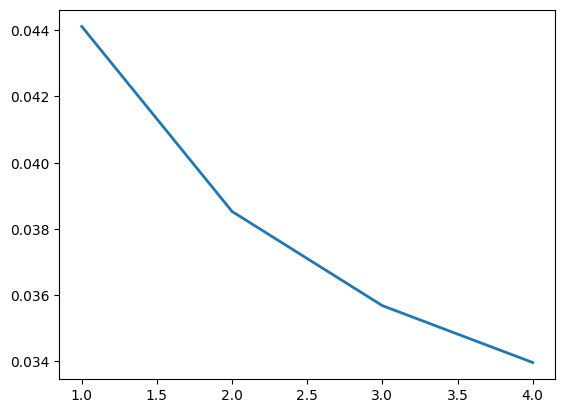

In [13]:
save_name1 = 'XGB-Stepregression_besttitles'+str(len(title[bestfeatlist]))+c_time+'.txt'
save_name2 = Path('.', DIR, save_name1)
with open(save_name2,"w") as f:
    np.savetxt(save_name2,title[bestfeatlist], fmt='%s', delimiter=',', comments='!')
f.close()
import matplotlib.pyplot as plt
import numpy as np
# mselist.insert( 0, perf0)
# make data
x = np.linspace(1, Stepfeatnum-1,Stepfeatnum-1)
print(len(mselist))
y = mselist
# plot
fig, ax = plt.subplots()
ax.plot(x, y, linewidth=2.0)
plt.show()

In [14]:
from sklearn import model_selection
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import joblib
def poolfit(TRAIN_TEST_SPLIT,EPOCH,CORE_NUM,X, y, paras,Xrealtest):
    r_l = []
    split_l=[]
    test_idx_m=[]
    point = round(X.shape[0]*TRAIN_TEST_SPLIT)
    for _ in range(int(EPOCH/CORE_NUM)):
        print('Round', CORE_NUM*(_)+1, 'Begin:')
        pool = Pool(CORE_NUM)
        for __ in range(CORE_NUM):
            permutation = np.random.permutation(y.shape[0])
            train_idx = permutation[:point]
            test_idx = permutation[point:]
            X_train = X[train_idx, :]
            y_train = y[train_idx]
            X_test = X[test_idx, :]
            y_test = y[test_idx]
            split_l.append(train_idx)
            test_idx_m.append(test_idx)
            r = pool.apply_async(XGB_Fit, args=(X, y, X_train, y_train, X_test, y_test, paras,))
            r_l.append(r)
        pool.close()
        pool.join()

    mse_list=[]
    mae_list=[]
    r2_list=[]
    results = r.get()
    shap_m = np.zeros((S_N-len(Xrealtest), len(X[0])))
    full_m=np.zeros((len(r_l),X.shape[0]))
    y_realtest_pred_list = []
    for i in range(len(r_l)):
        r = r_l[i]
        results = r.get()
        temp = results[0]
        mse = temp[0]
        mae = temp[1]
        r2 = temp[2]
        shap_m += temp[3] 
        clf_new=results[1]
        mse_list.append(mse)
        mae_list.append(mae)
        r2_list.append(r2)
        train_idx = split_l[i]
        test_idx = []
        for j in range(X.shape[0]):
            if j not in train_idx:
                test_idx.append(j)
        X_train = X[train_idx, :]
        y_train = y[train_idx]
        X_test = X[test_idx, :]
        y_test = y[test_idx]
        y_full_pred = clf_new.predict(X)
        y_realtest_pred=clf_new.predict(Xrealtest)
#         print(y_realtest_pred)
        y_realtest_pred_list.append(y_realtest_pred)
        
#         print(y_full_pred[0])
        full_m[i]=np.array(y_full_pred)
    mse1=np.mean(mse_list)
    mae1=np.mean(mae_list)
    r21=np.mean(r2_list)
    mse2=np.std(mse_list)
    shap_m2 = shap_m/len(r2_list)
    y_realtest_pred_std = np.std(y_realtest_pred_list, axis=0)
    temp = [mse1, mae1, r21,full_m,test_idx_m,mse2,shap_m2,y_realtest_pred,y_realtest_pred_std]
    return temp
def XGB_Fit(X, y, X_train, y_train, X_test, y_test, paras):
    clf_new = XGBRegressor()
    for k, v in paras.items():
        clf_new.set_params(**{k: v})
    # print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
    # 拟合模型
    clf_new.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=150, verbose=False)
    # 计算损失
    y_pred = clf_new.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    shap_values = shap.TreeExplainer(clf_new).shap_values(X)
    temp0 = [mse, mae, r2, shap_values]
    print('   MSE: %.5f' % mse, '  MAE: %.5f' % mae, '  R^2: %.5f' % r2)
    return (temp0, clf_new)


# Create clf (sklean的API)
shap_m = np.zeros((S_N, len(X[0])))
paras = clf.get_params()
mse_list = []
mae_list = []
r2_list = []
f_i = np.zeros((title.shape[0], 1))
max_r2 = -999.9

In [15]:
title[bestfeatlist]

array(['buriedH5', 'N27aliemin', 'N1espmin', 'buriedH6',
       'Asymmetry_Ratio'], dtype='<U48')

In [16]:
# bestfeatlist=[8, 84, 89, 68, 109, 2]
# title[bestfeatlist]

X: (39, 62)    y: (39,)
[4]
1
Round 1 Begin:
   MSE: 0.10695   MSE: 0.06449   MAE: 0.25729     MSE: 0.08634  MAE: 0.19505  R^2: 0.25276
    MAE: 0.25200   R^2: 0.38135  R^2: 0.27679

   MSE: 0.02274   MAE: 0.13456   R^2: 0.23777
   MSE: 0.04625   MAE: 0.19681   R^2: -0.63745
   MSE: 0.03590   MAE: 0.18001    MSE: 0.06996  R^2: 0.67070 
  MAE: 0.22389   MSE: 0.03888   MSE: 0.10423    MSE: 0.05762  R^2: 0.54407   MAE: 0.28809  MAE: 0.22363  
  MAE: 0.17707     R^2: 0.17833  R^2: 0.58879  R^2: 0.11834


   MSE: 0.05874   MSE: 0.13751   MSE: 0.07087     MAE: 0.19940   MSE: 0.06174  MAE: 0.32183  MAE: 0.23195      R^2: -6.10596  R^2: -0.44877  R^2: 0.36483  MAE: 0.21113


   R^2: 0.51771
   MSE: 0.02670   MAE: 0.13192   R^2: 0.80290
   MSE: 0.07934   MSE: 0.07976    MAE: 0.17523  MAE: 0.22364     MSE: 0.11728   MSE: 0.06914  R^2: -1.51772  R^2: 0.34994  

  MAE: 0.27577  MAE: 0.21569     MSE: 0.05532  R^2: -0.54287  R^2: 0.16486

   MAE: 0.18790    MSE: 0.01194  R^2: 0.40019
    MSE: 0.1079

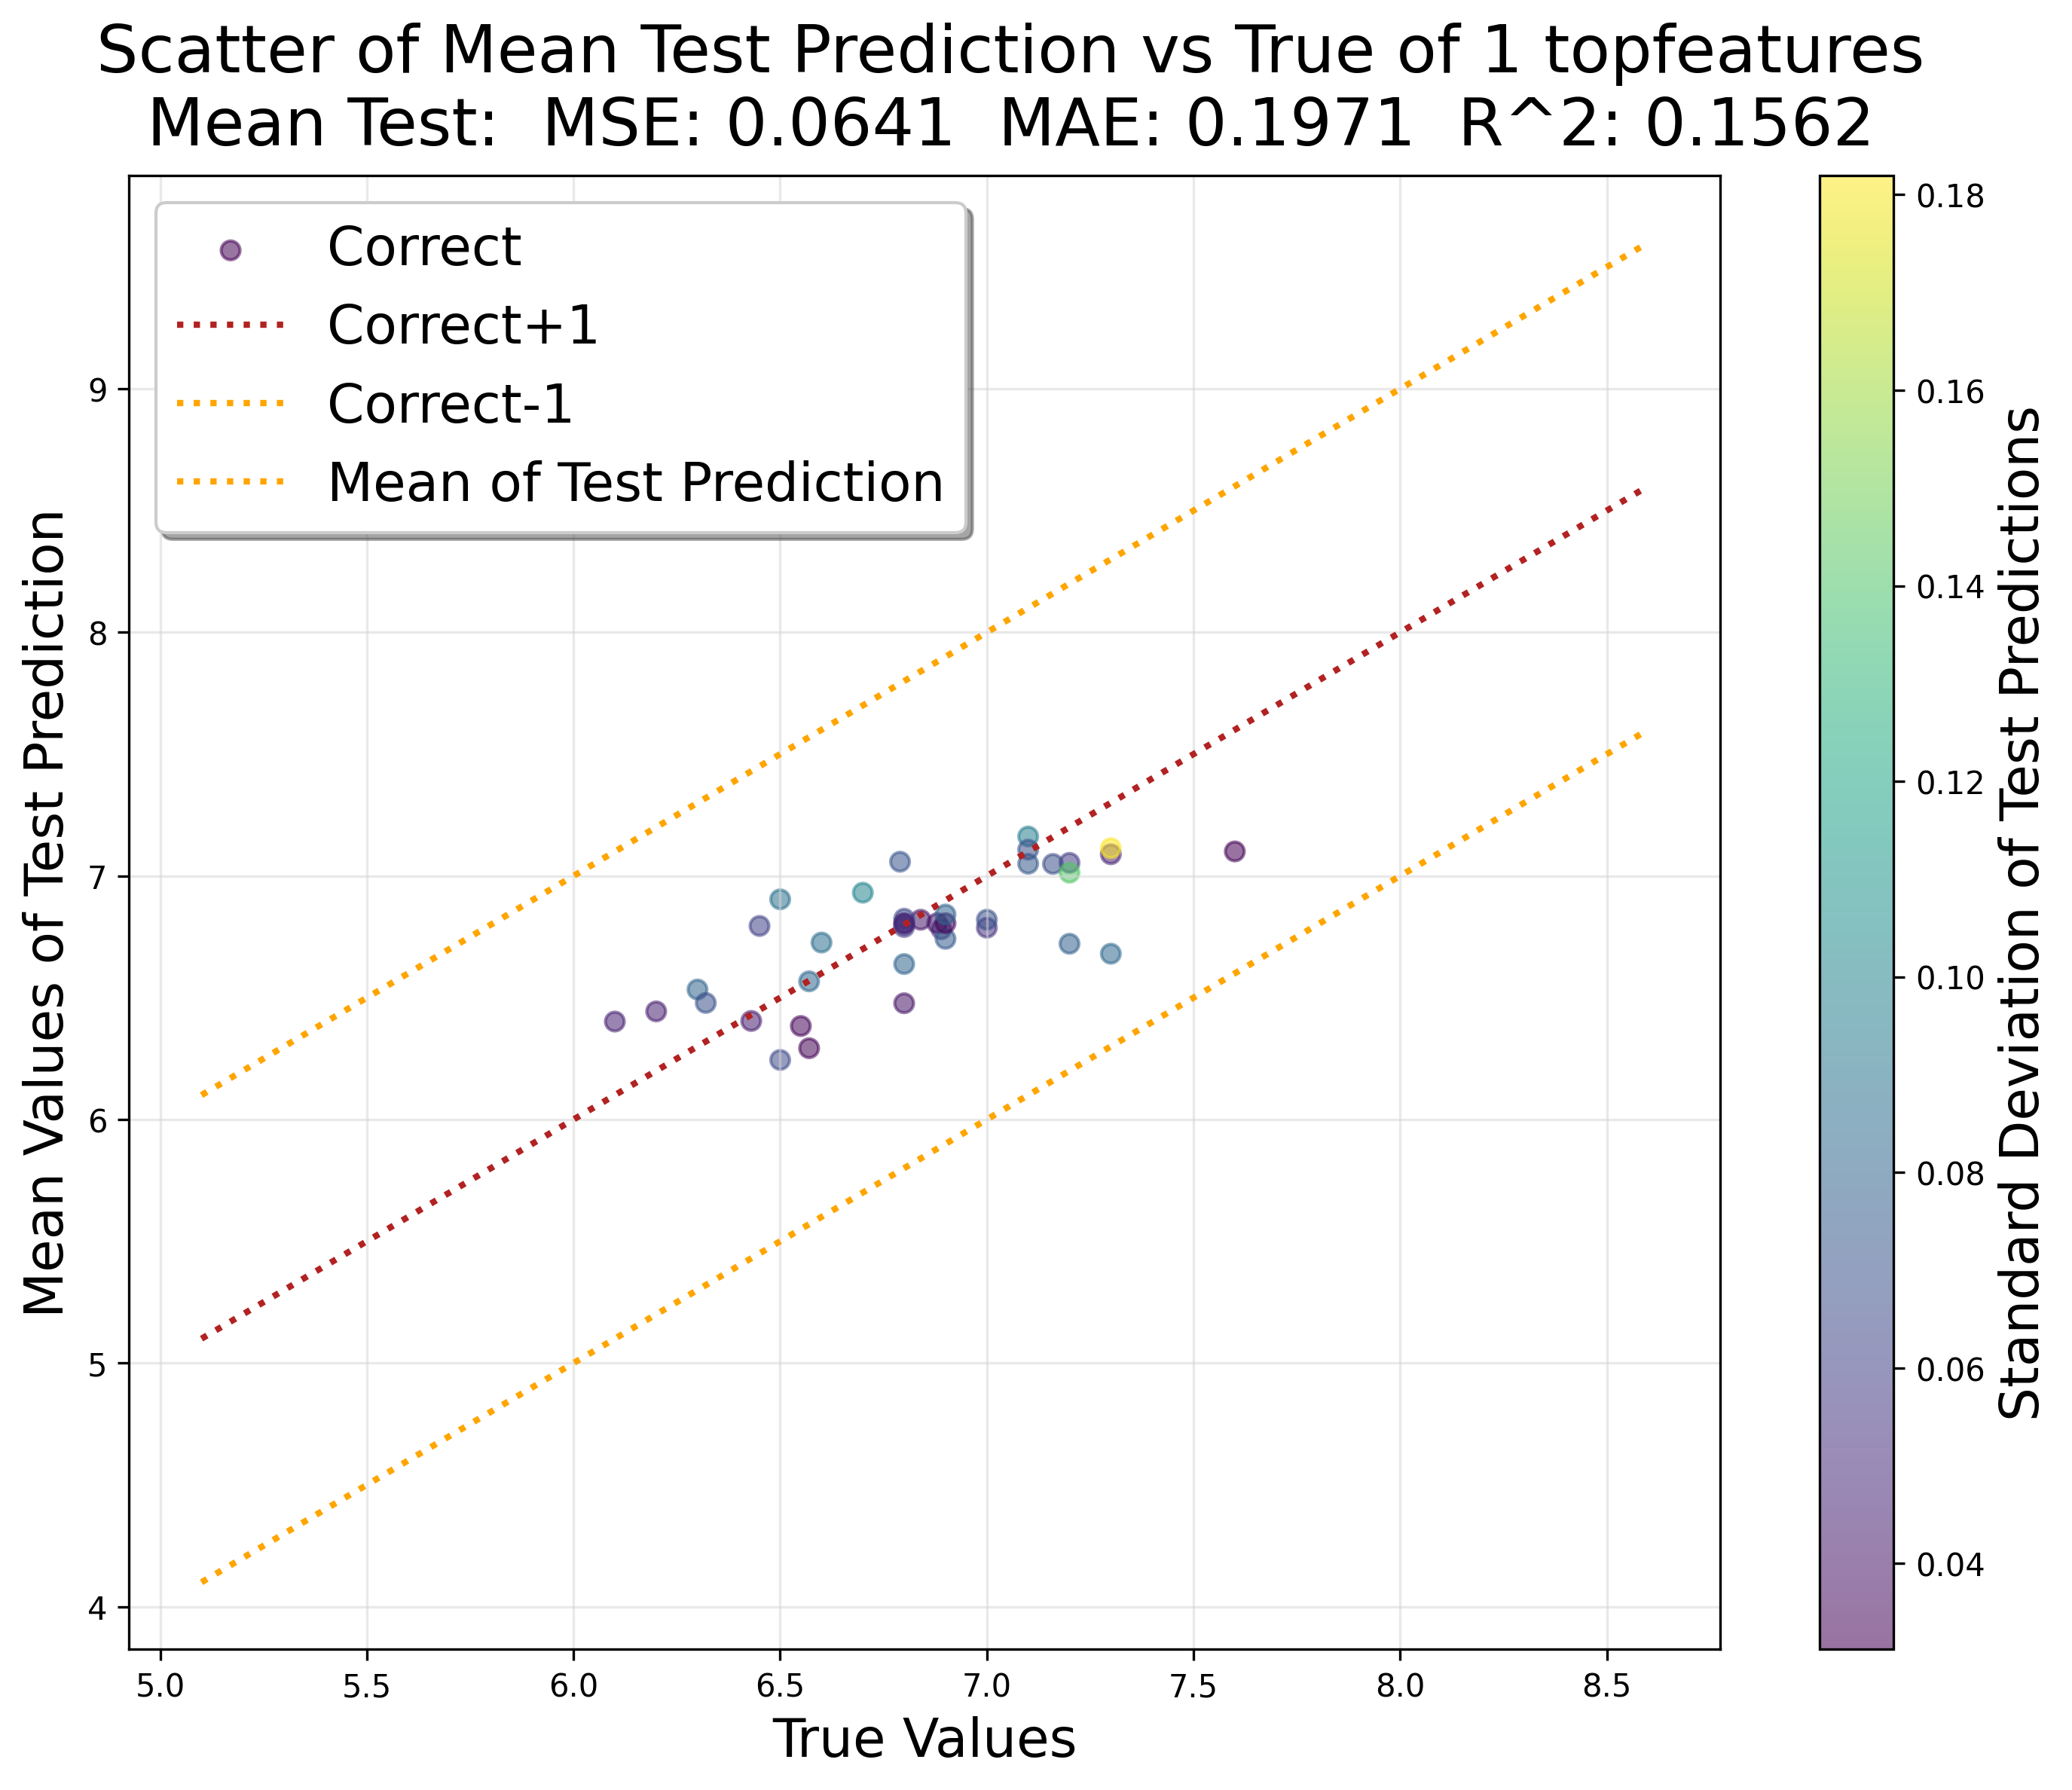

[4, 40]
2
Round 1 Begin:
   MSE: 0.03136   MSE: 0.05106    MAE: 0.18346  MAE: 0.13311    R^2: 0.76284  R^2: 0.29344

   MSE: 0.04088   MSE: 0.05673    MAE: 0.16768   MAE: 0.18122   R^2: 0.70490
  R^2: 0.55887
   MSE: 0.05175   MAE: 0.20238   R^2: 0.36376
   MSE: 0.04706   MAE: 0.18780   MSE: 0.03852   MSE: 0.10069    R^2: 0.39779    MSE: 0.04650   MSE: 0.01717  MAE: 0.17379  MAE: 0.24664 
   R^2: -0.56157    MAE: 0.17753
  R^2: 0.48512   MSE: 0.06349  MAE: 0.10762     R^2: 0.79529  R^2: 0.42361


  MAE: 0.20617   R^2: 0.10600
   MSE: 0.02186   MAE: 0.12340   R^2: 0.79125   MSE: 0.04492
    MSE: 0.04095  MAE: 0.15426   MSE: 0.03593     R^2: 0.42426  MAE: 0.15548
  MAE: 0.15266    R^2: 0.66309
  R^2: 0.61249
   MSE: 0.05336   MSE: 0.07105    MAE: 0.19496  MAE: 0.23585    R^2: 0.29631   MSE: 0.08263  R^2: 0.07881

    MSE: 0.04090  MAE: 0.27805    MSE: 0.04930   MAE: 0.16821  R^2: -0.22620 
   MAE: 0.17973  R^2: 0.65246   MSE: 0.01963 
  R^2: 0.20921 
  MAE: 0.12442   MSE: 0.00750   R^2: 

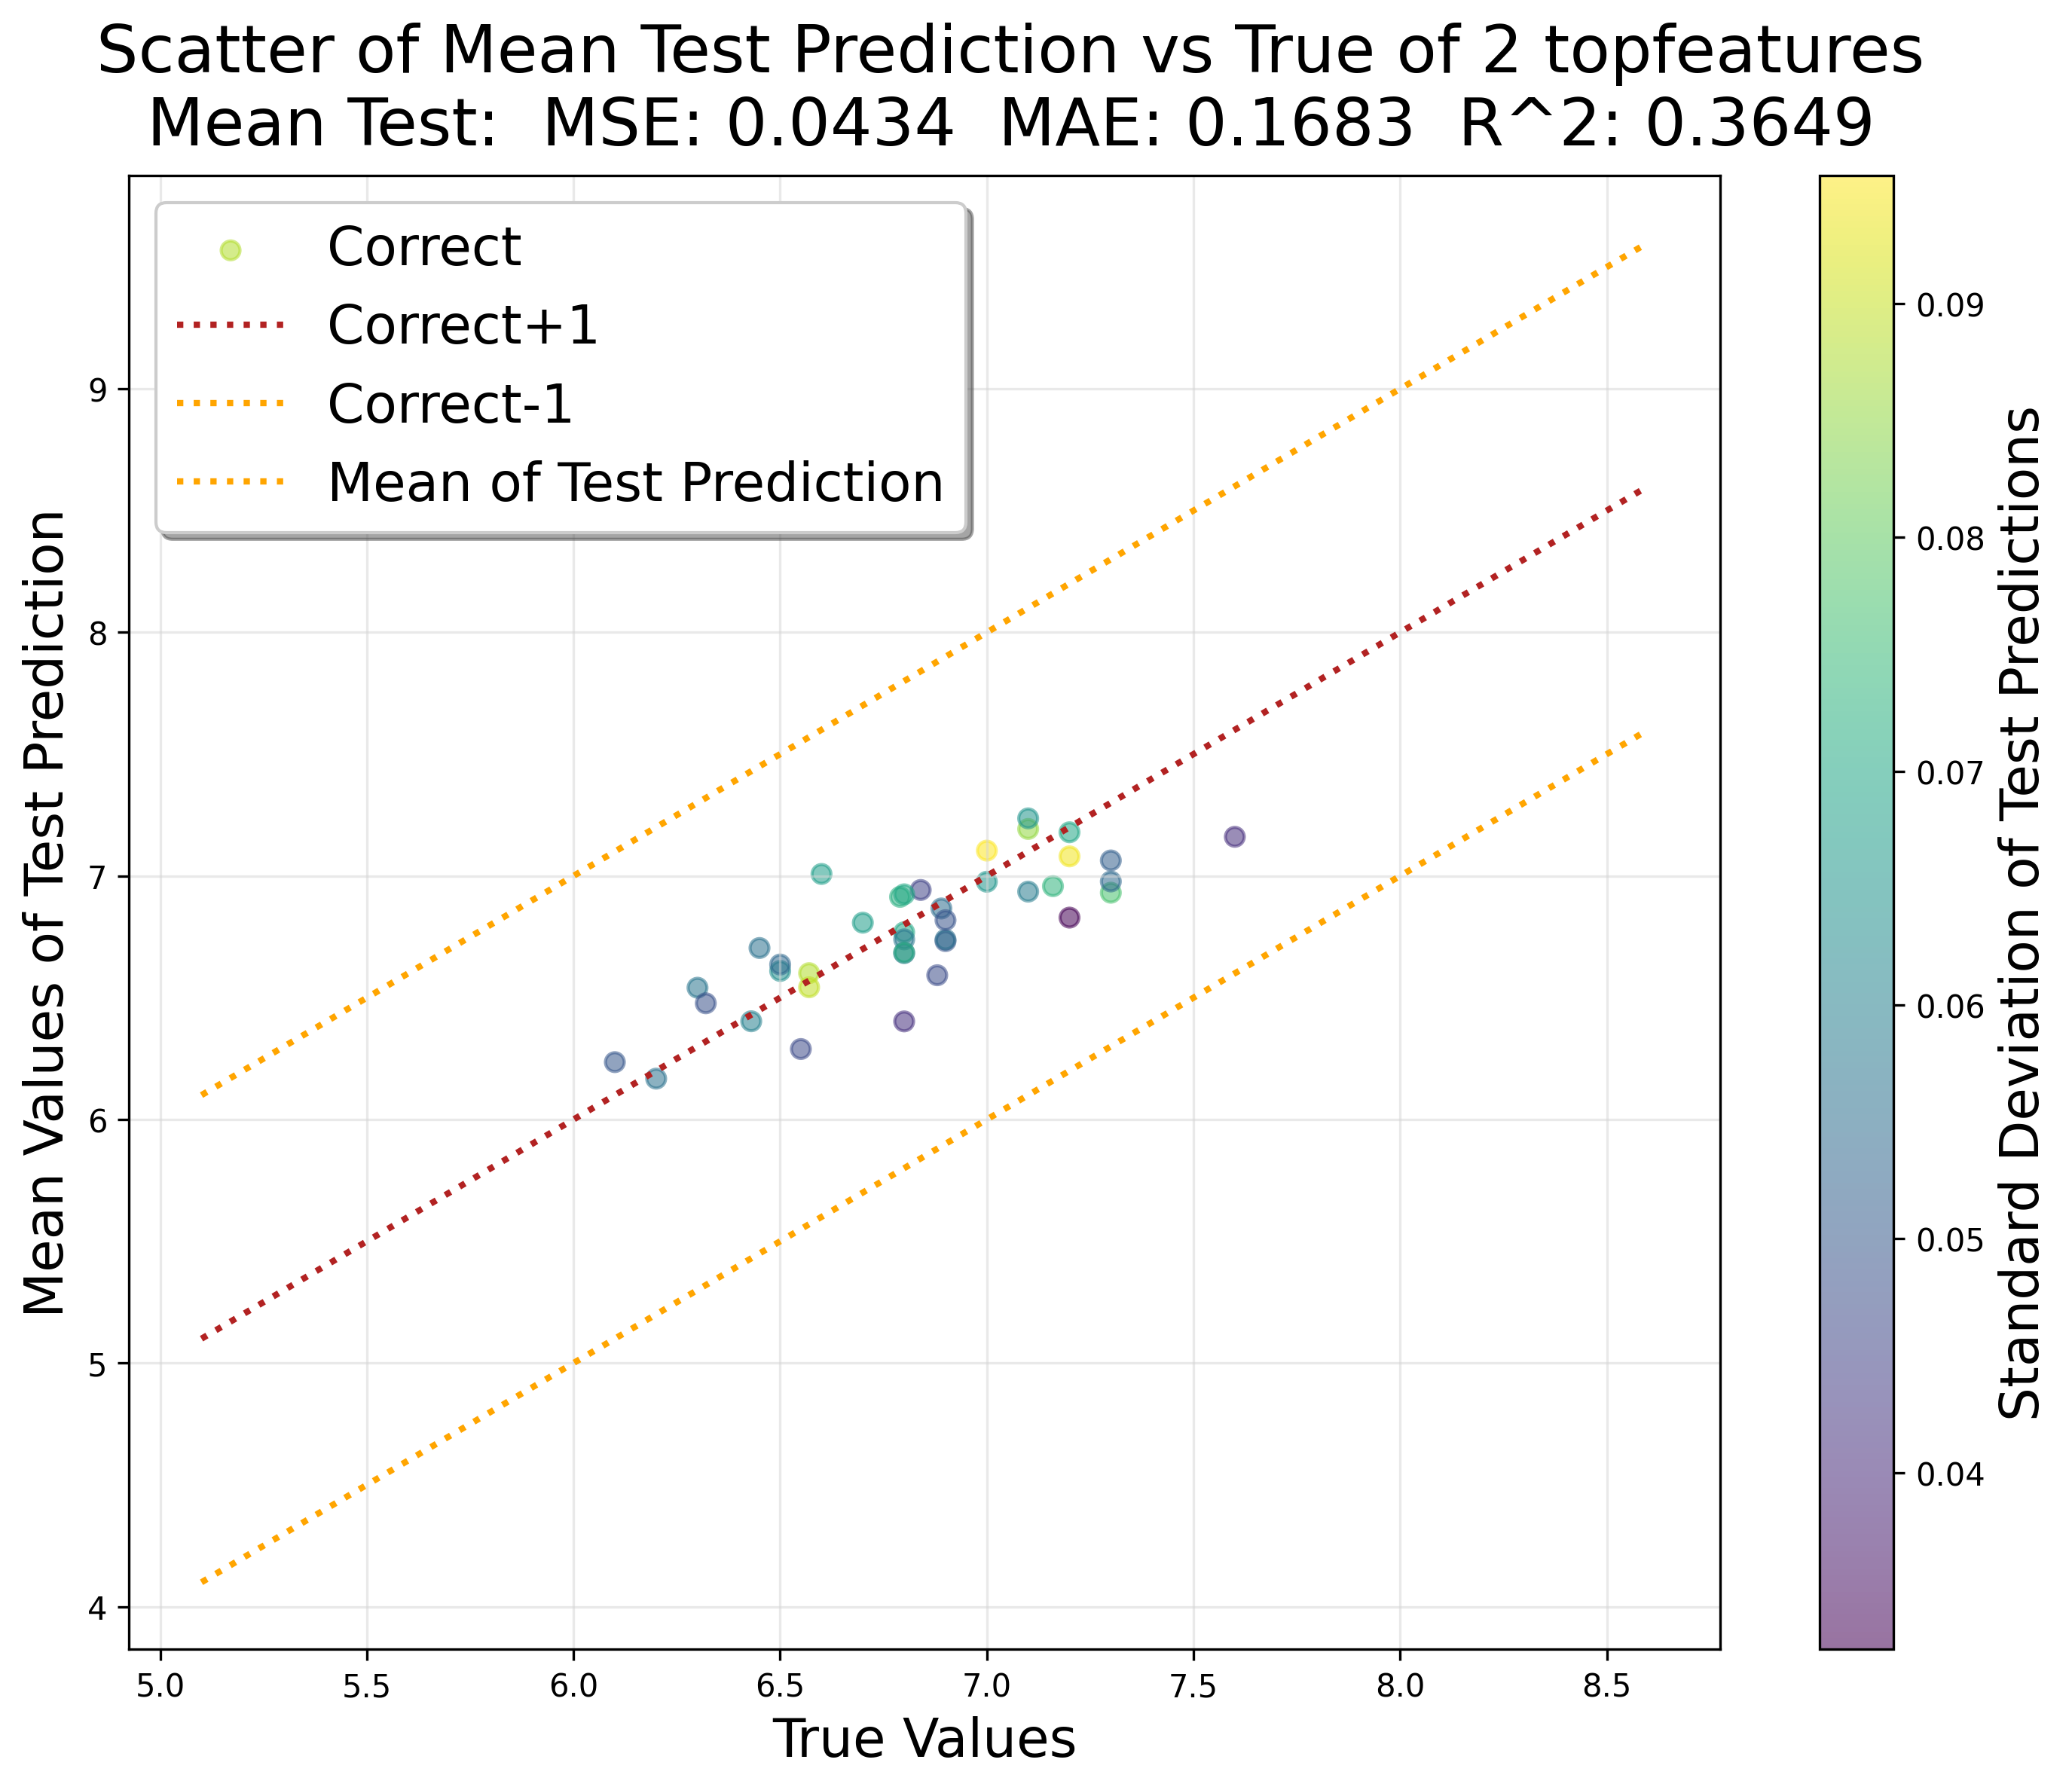

[4, 40, 20]
3
Round 1 Begin:
   MSE: 0.00717   MAE: 0.06650   R^2: 0.79860
   MSE: 0.02359   MSE: 0.03459    MAE: 0.13309  MAE: 0.15585     MSE: 0.10453  R^2: 0.72257  R^2: 0.65716 

  MAE: 0.28110   MSE: 0.05301    R^2: 0.29924
  MAE: 0.19549    MSE: 0.02778   MSE: 0.03251  R^2: 0.38834 
  MAE: 0.14706   MAE: 0.17072    R^2: 0.72564  R^2: 0.78546   MSE: 0.03640
   MSE: 0.02833
     MSE: 0.04718  MAE: 0.15689  MAE: 0.11848     R^2: 0.21343  R^2: 0.81785  MAE: 0.18292   MSE: 0.06641

    R^2: 0.81654  MAE: 0.23773
   R^2: 0.27945
   MSE: 0.01591   MAE: 0.11016   R^2: 0.83064
   MSE: 0.03658   MSE: 0.04826    MAE: 0.16316  MAE: 0.16385    R^2: 0.67660  R^2: -0.05486
   MSE: 0.06015   MSE: 0.03775
    MSE: 0.02808    MSE: 0.03035  MAE: 0.21599   MSE: 0.02758   MAE: 0.16566     MSE: 0.02599  MAE: 0.14406   MSE: 0.03004   R^2: 0.61283  MAE: 0.15430   
  MAE: 0.13017    R^2: 0.78819  R^2: 0.51447  MAE: 0.12730   MAE: 0.14664
  R^2: -0.51622
   R^2: 0.78647   R^2: 0.68240  R^2: -0.34558



  

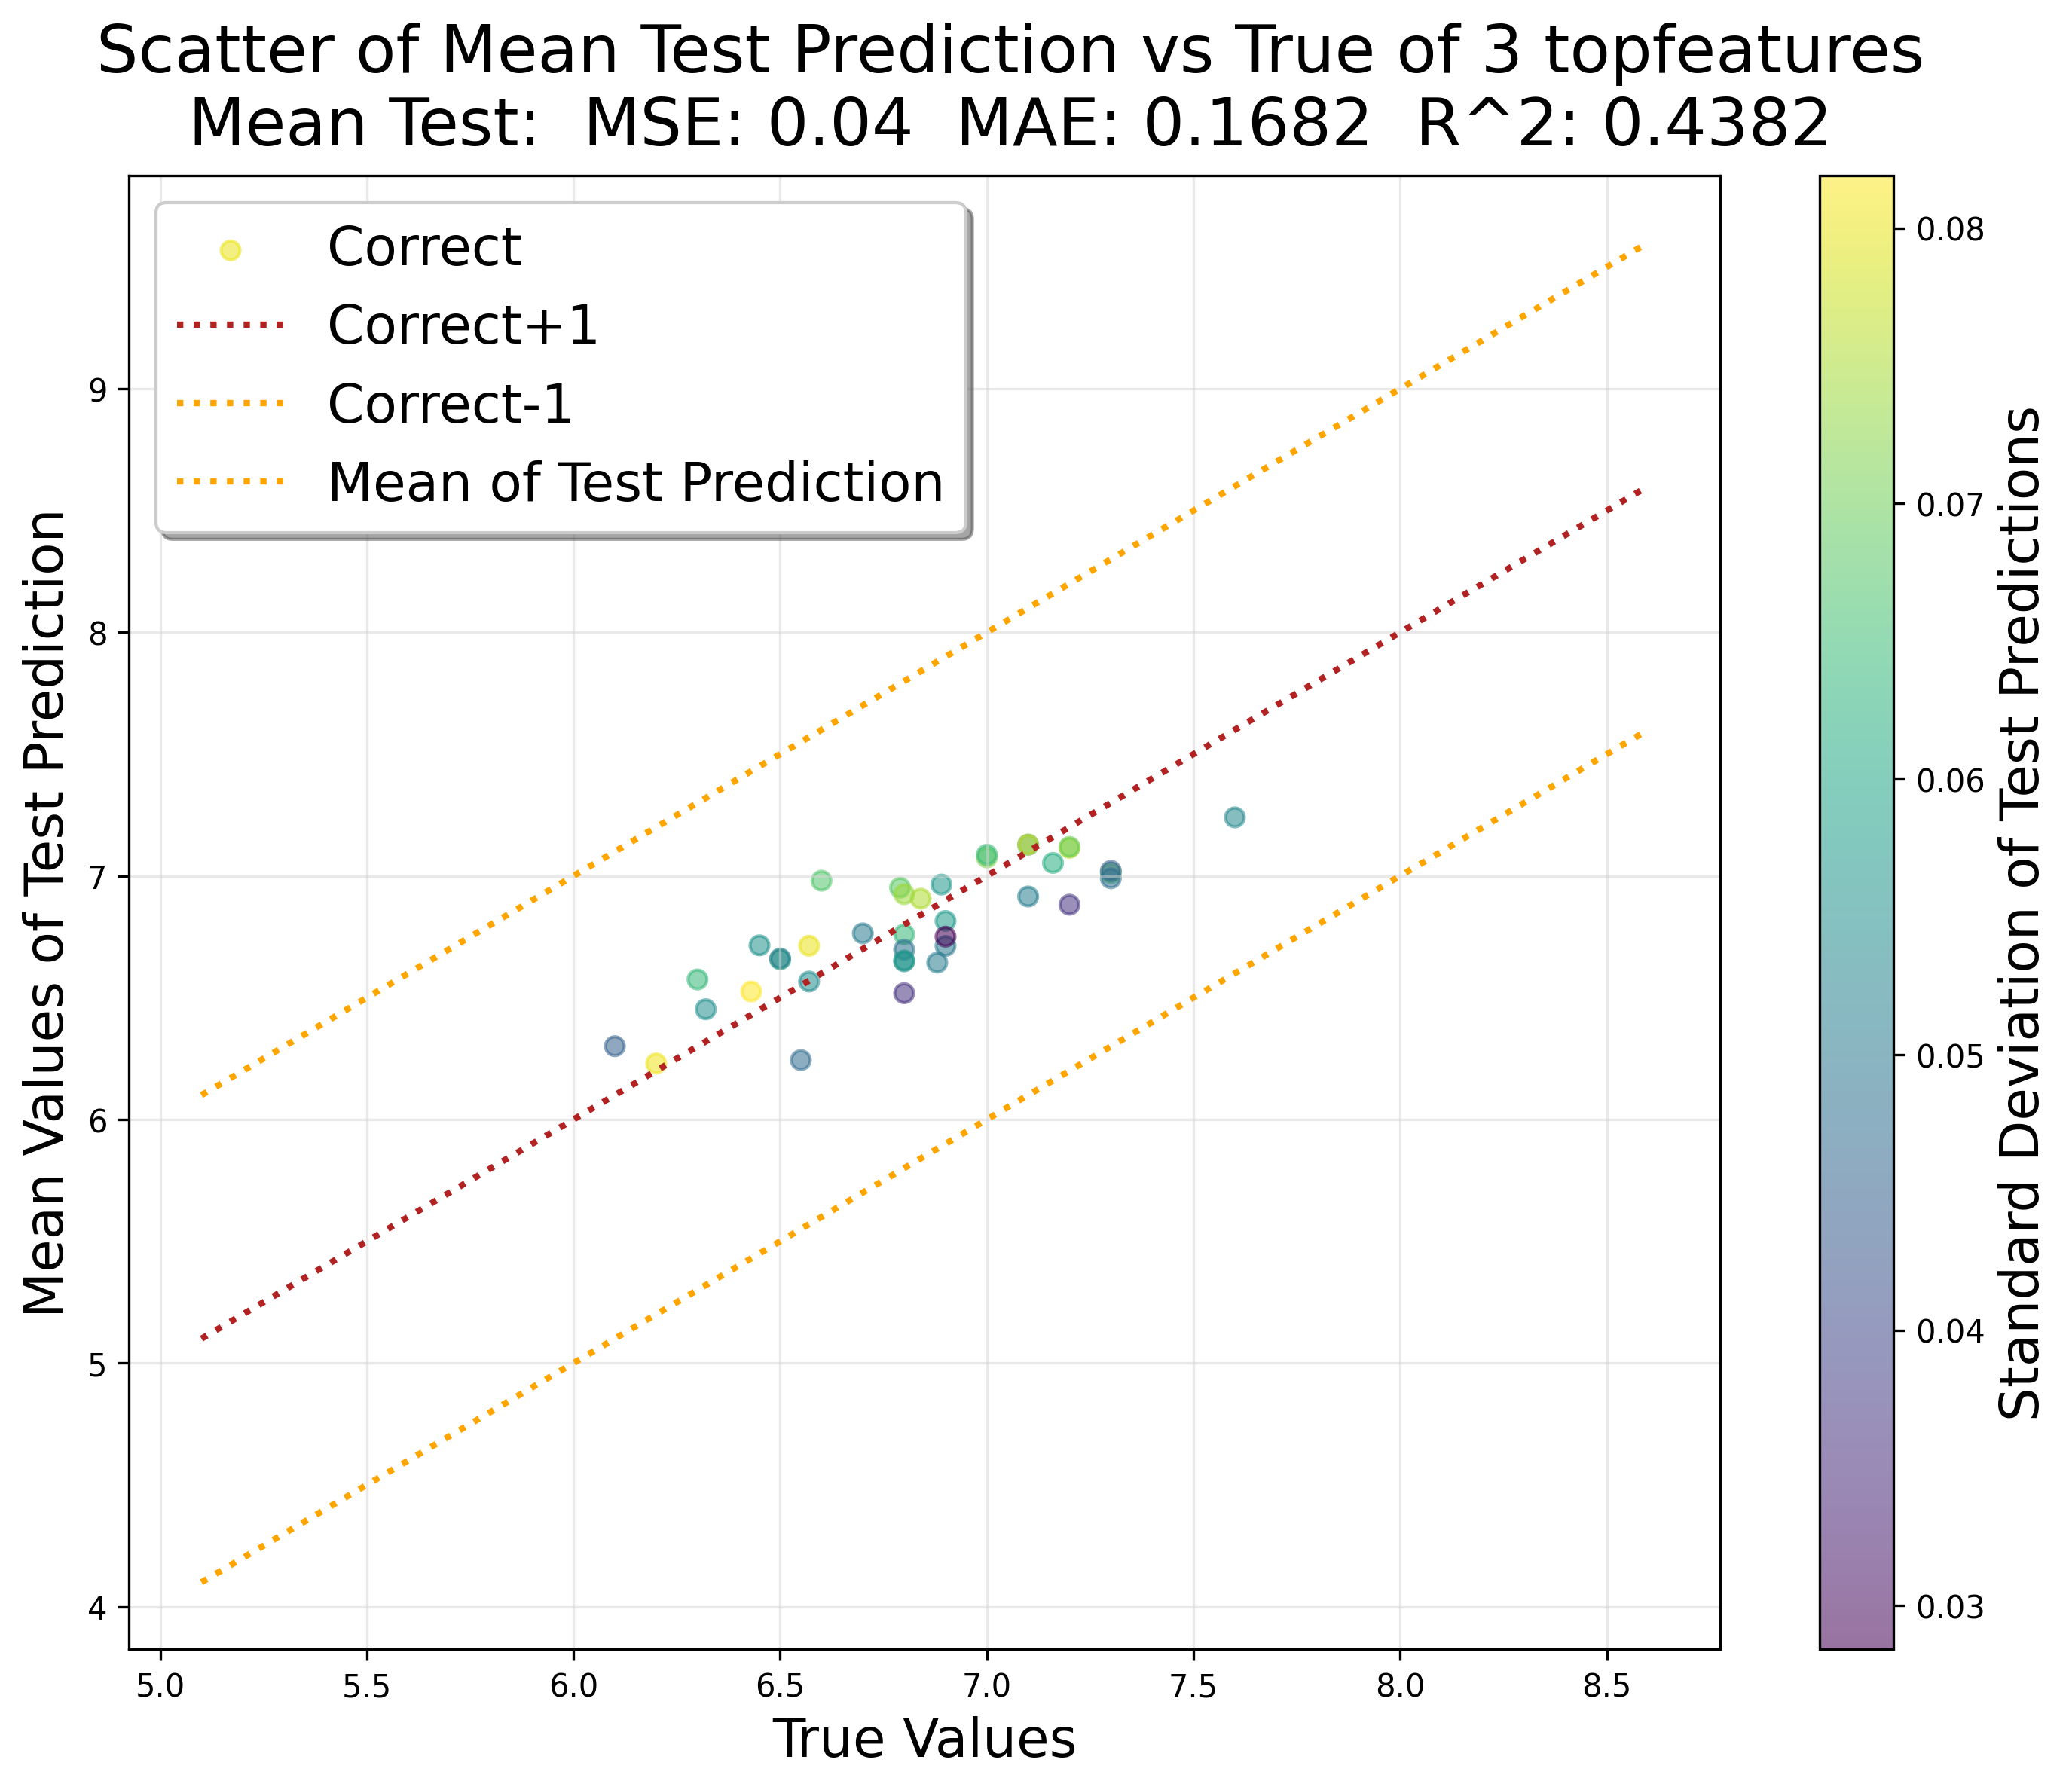

[4, 40, 20, 5]
4
Round 1 Begin:
   MSE: 0.04653   MSE: 0.06017   MAE: 0.19448   MAE: 0.21685   R^2: 0.66042
   R^2: -0.26908
   MSE: 0.03466   MAE: 0.13842    MSE: 0.01208  R^2: 0.70714
   MAE: 0.08564 
  R^2: 0.79513   MSE: 0.01768   MAE: 0.11633    MSE: 0.02472  R^2: 0.10759 
  MAE: 0.11497   R^2: 0.72857
   MSE: 0.04759   MAE: 0.19950   R^2: -0.10616
   MSE: 0.04177   MSE: 0.03135    MSE: 0.05431   MAE: 0.17535   MSE: 0.02892   MAE: 0.14670    MSE: 0.01800  MAE: 0.19598    R^2: 0.71687   MSE: 0.03432   MAE: 0.14446   R^2: 0.57249
  R^2: 0.39520   MAE: 0.10823 

  MAE: 0.15196   R^2: 0.74123   R^2: 0.69505
  R^2: 0.05567

   MSE: 0.00281   MSE: 0.03812    MAE: 0.03882  MAE: 0.17272    R^2: 0.96250  R^2: 0.45806

   MSE: 0.02802   MAE: 0.12205   R^2: 0.46828
   MSE: 0.02426   MAE: 0.12759   R^2: 0.66310
   MSE: 0.02613   MAE: 0.14802   R^2: 0.33255
   MSE: 0.04066   MSE: 0.03961    MAE: 0.17653  MAE: 0.16078    MSE: 0.02805   R^2: 0.76200  R^2: 0.66681 

  MAE: 0.13491   R^2: 0.49505


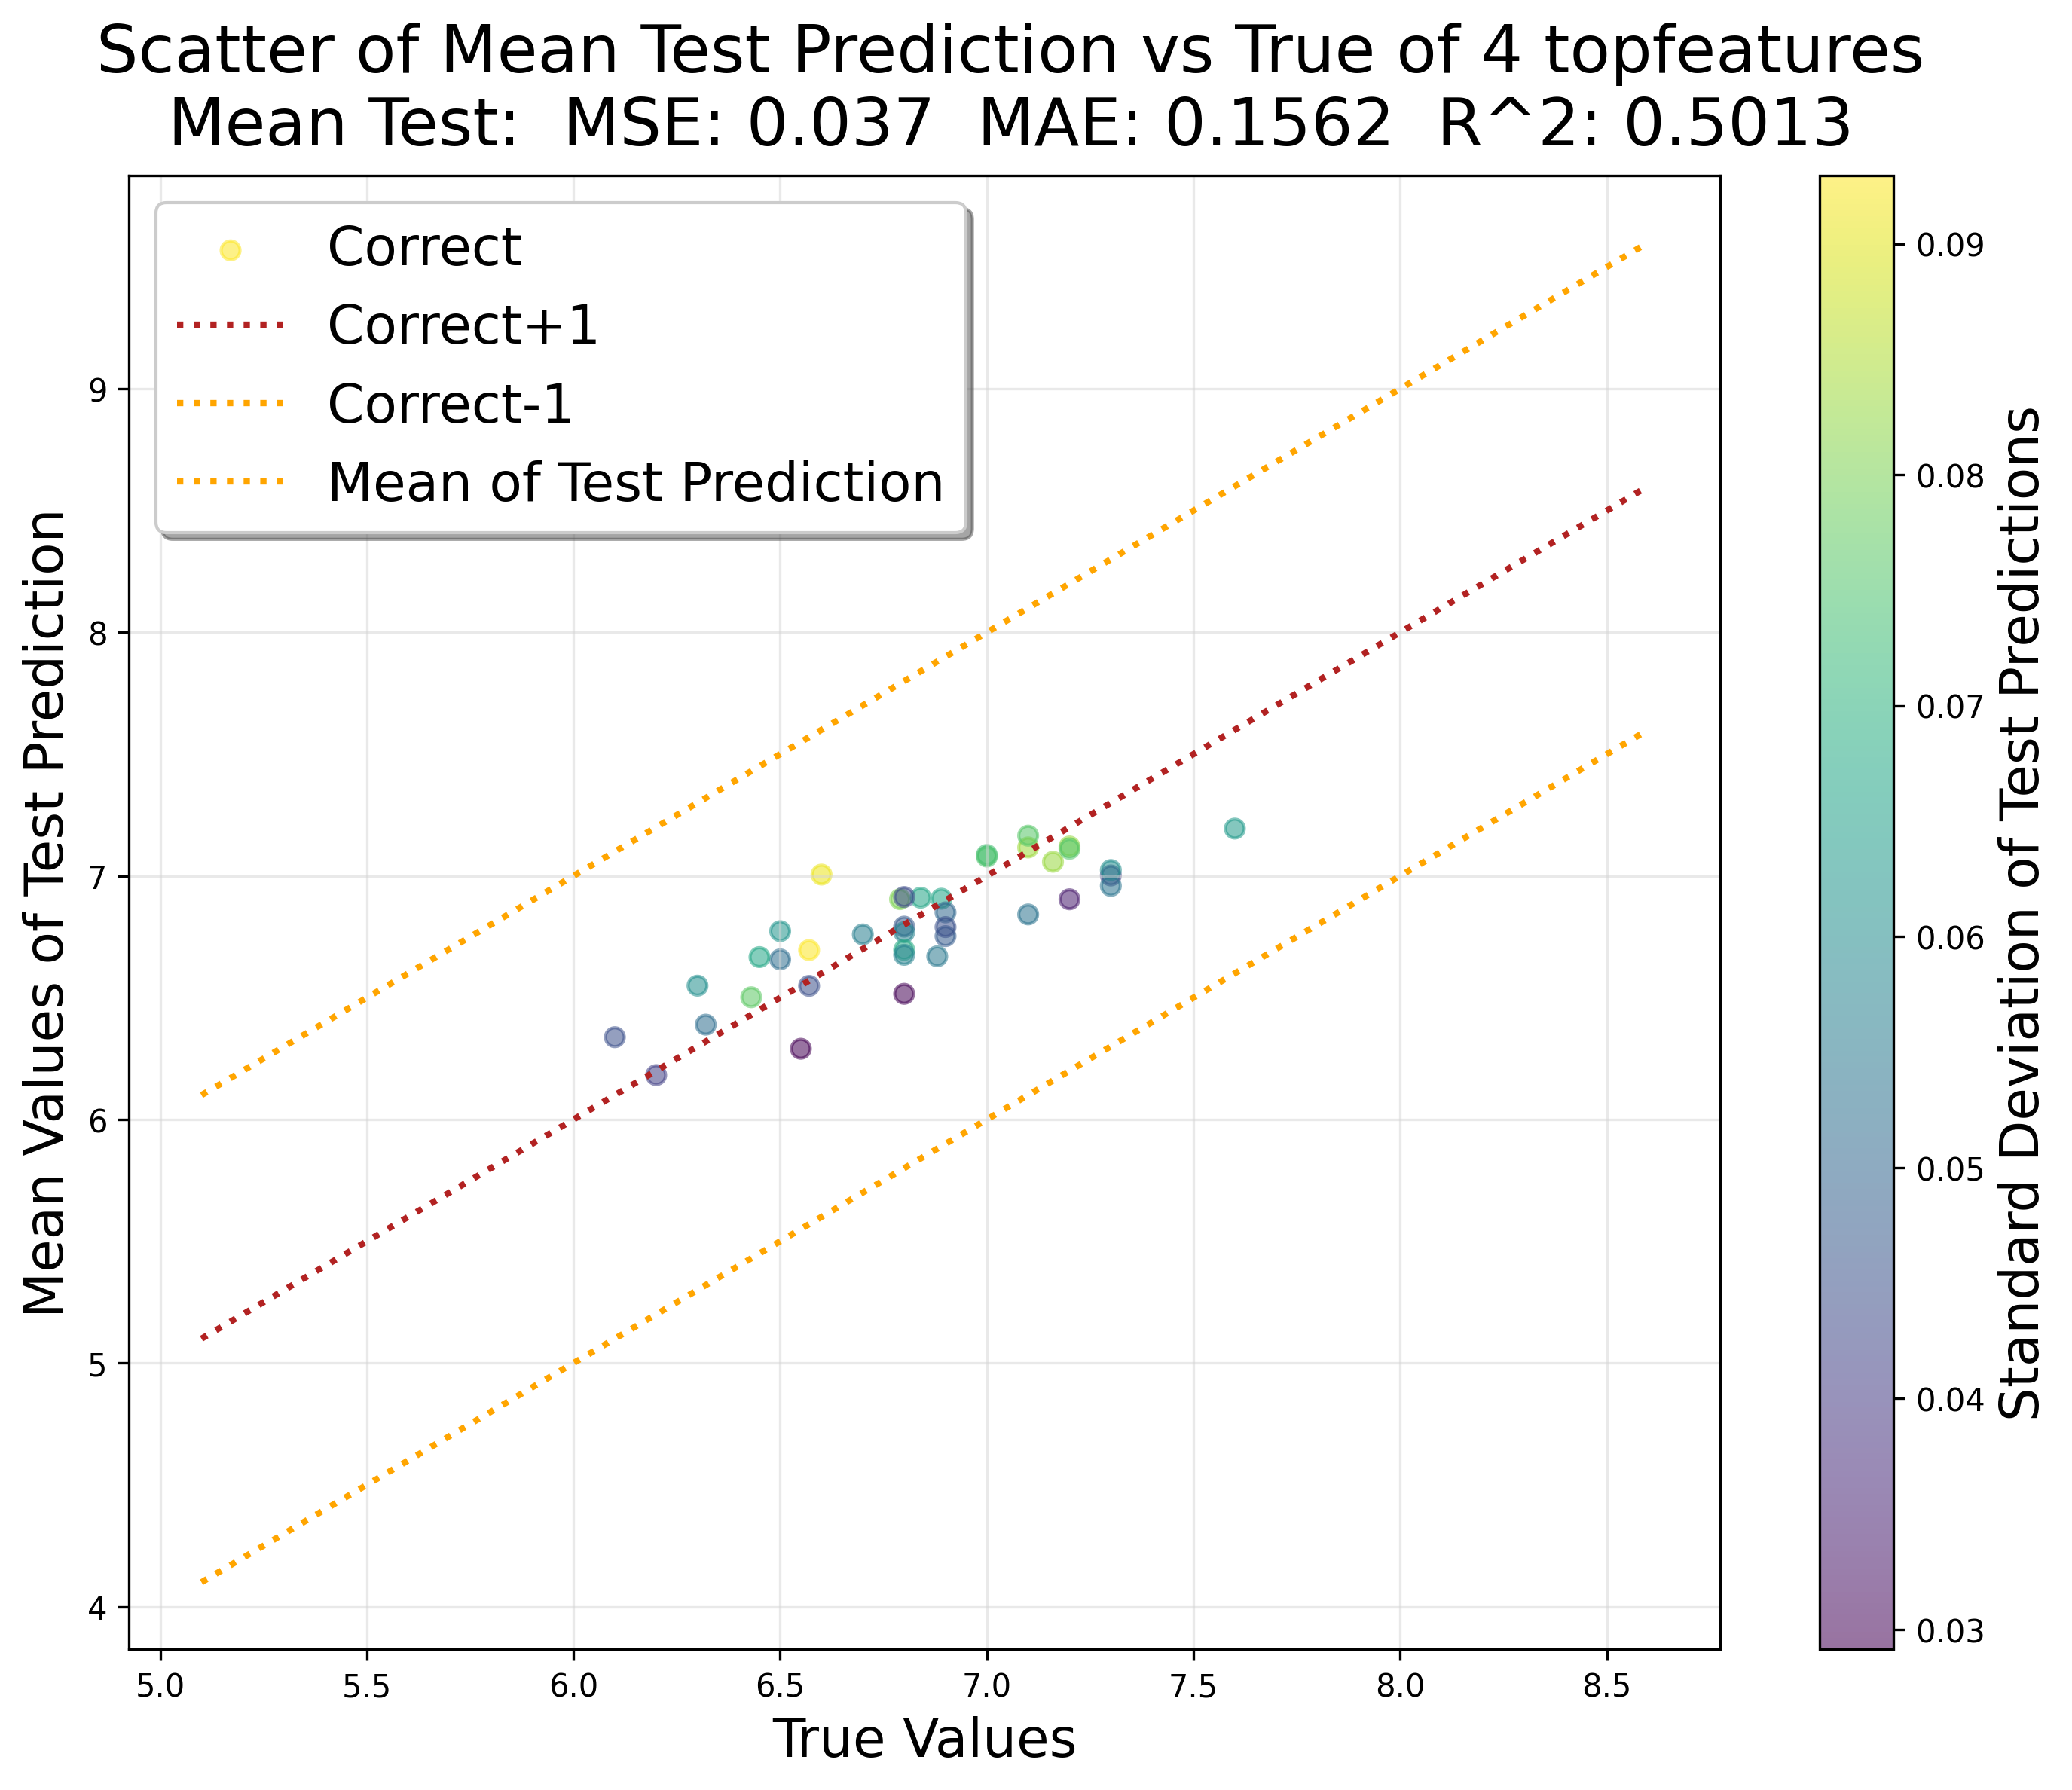

[4, 40, 20, 5, 49]
5
Round 1 Begin:
   MSE: 0.01807   MAE: 0.11795   R^2: 0.73871
   MSE: 0.03068   MAE: 0.15909    MSE: 0.05517   MSE: 0.04774   MAE: 0.18870    MSE: 0.04775    R^2: 0.60044  R^2: 0.73038  MAE: 0.19220

   MAE: 0.19767  R^2: 0.68631 
  R^2: 0.13358
   MSE: 0.01883   MAE: 0.11322   R^2: 0.65485
   MSE: 0.03380   MSE: 0.01013    MAE: 0.14614   MSE: 0.02067   MAE: 0.08787  R^2: -0.27722   MSE: 0.01802    MSE: 0.01067
    MAE: 0.13125   R^2: 0.83432  MAE: 0.11679  
  MAE: 0.09259  R^2: 0.80265  R^2: -0.08611   MSE: 0.03718 

   R^2: 0.87524   MSE: 0.04798  MAE: 0.17476
   MSE: 0.00961     MSE: 0.02123  MAE: 0.18350   MSE: 0.04155  R^2: 0.64816      MSE: 0.03893
   MSE: 0.05659   R^2: 0.45585  MAE: 0.07640   MSE: 0.05575  MAE: 0.11172   MSE: 0.00661
  MAE: 0.15269        MSE: 0.02489    MAE: 0.14737  MAE: 0.18761   MSE: 0.04442   MSE: 0.02087   MSE: 0.01923  R^2: 0.75318  MAE: 0.18094  R^2: 0.55164  R^2: 0.71406   MSE: 0.05527  MAE: 0.07452   
    
   MSE: 0.02999
   MSE: 0

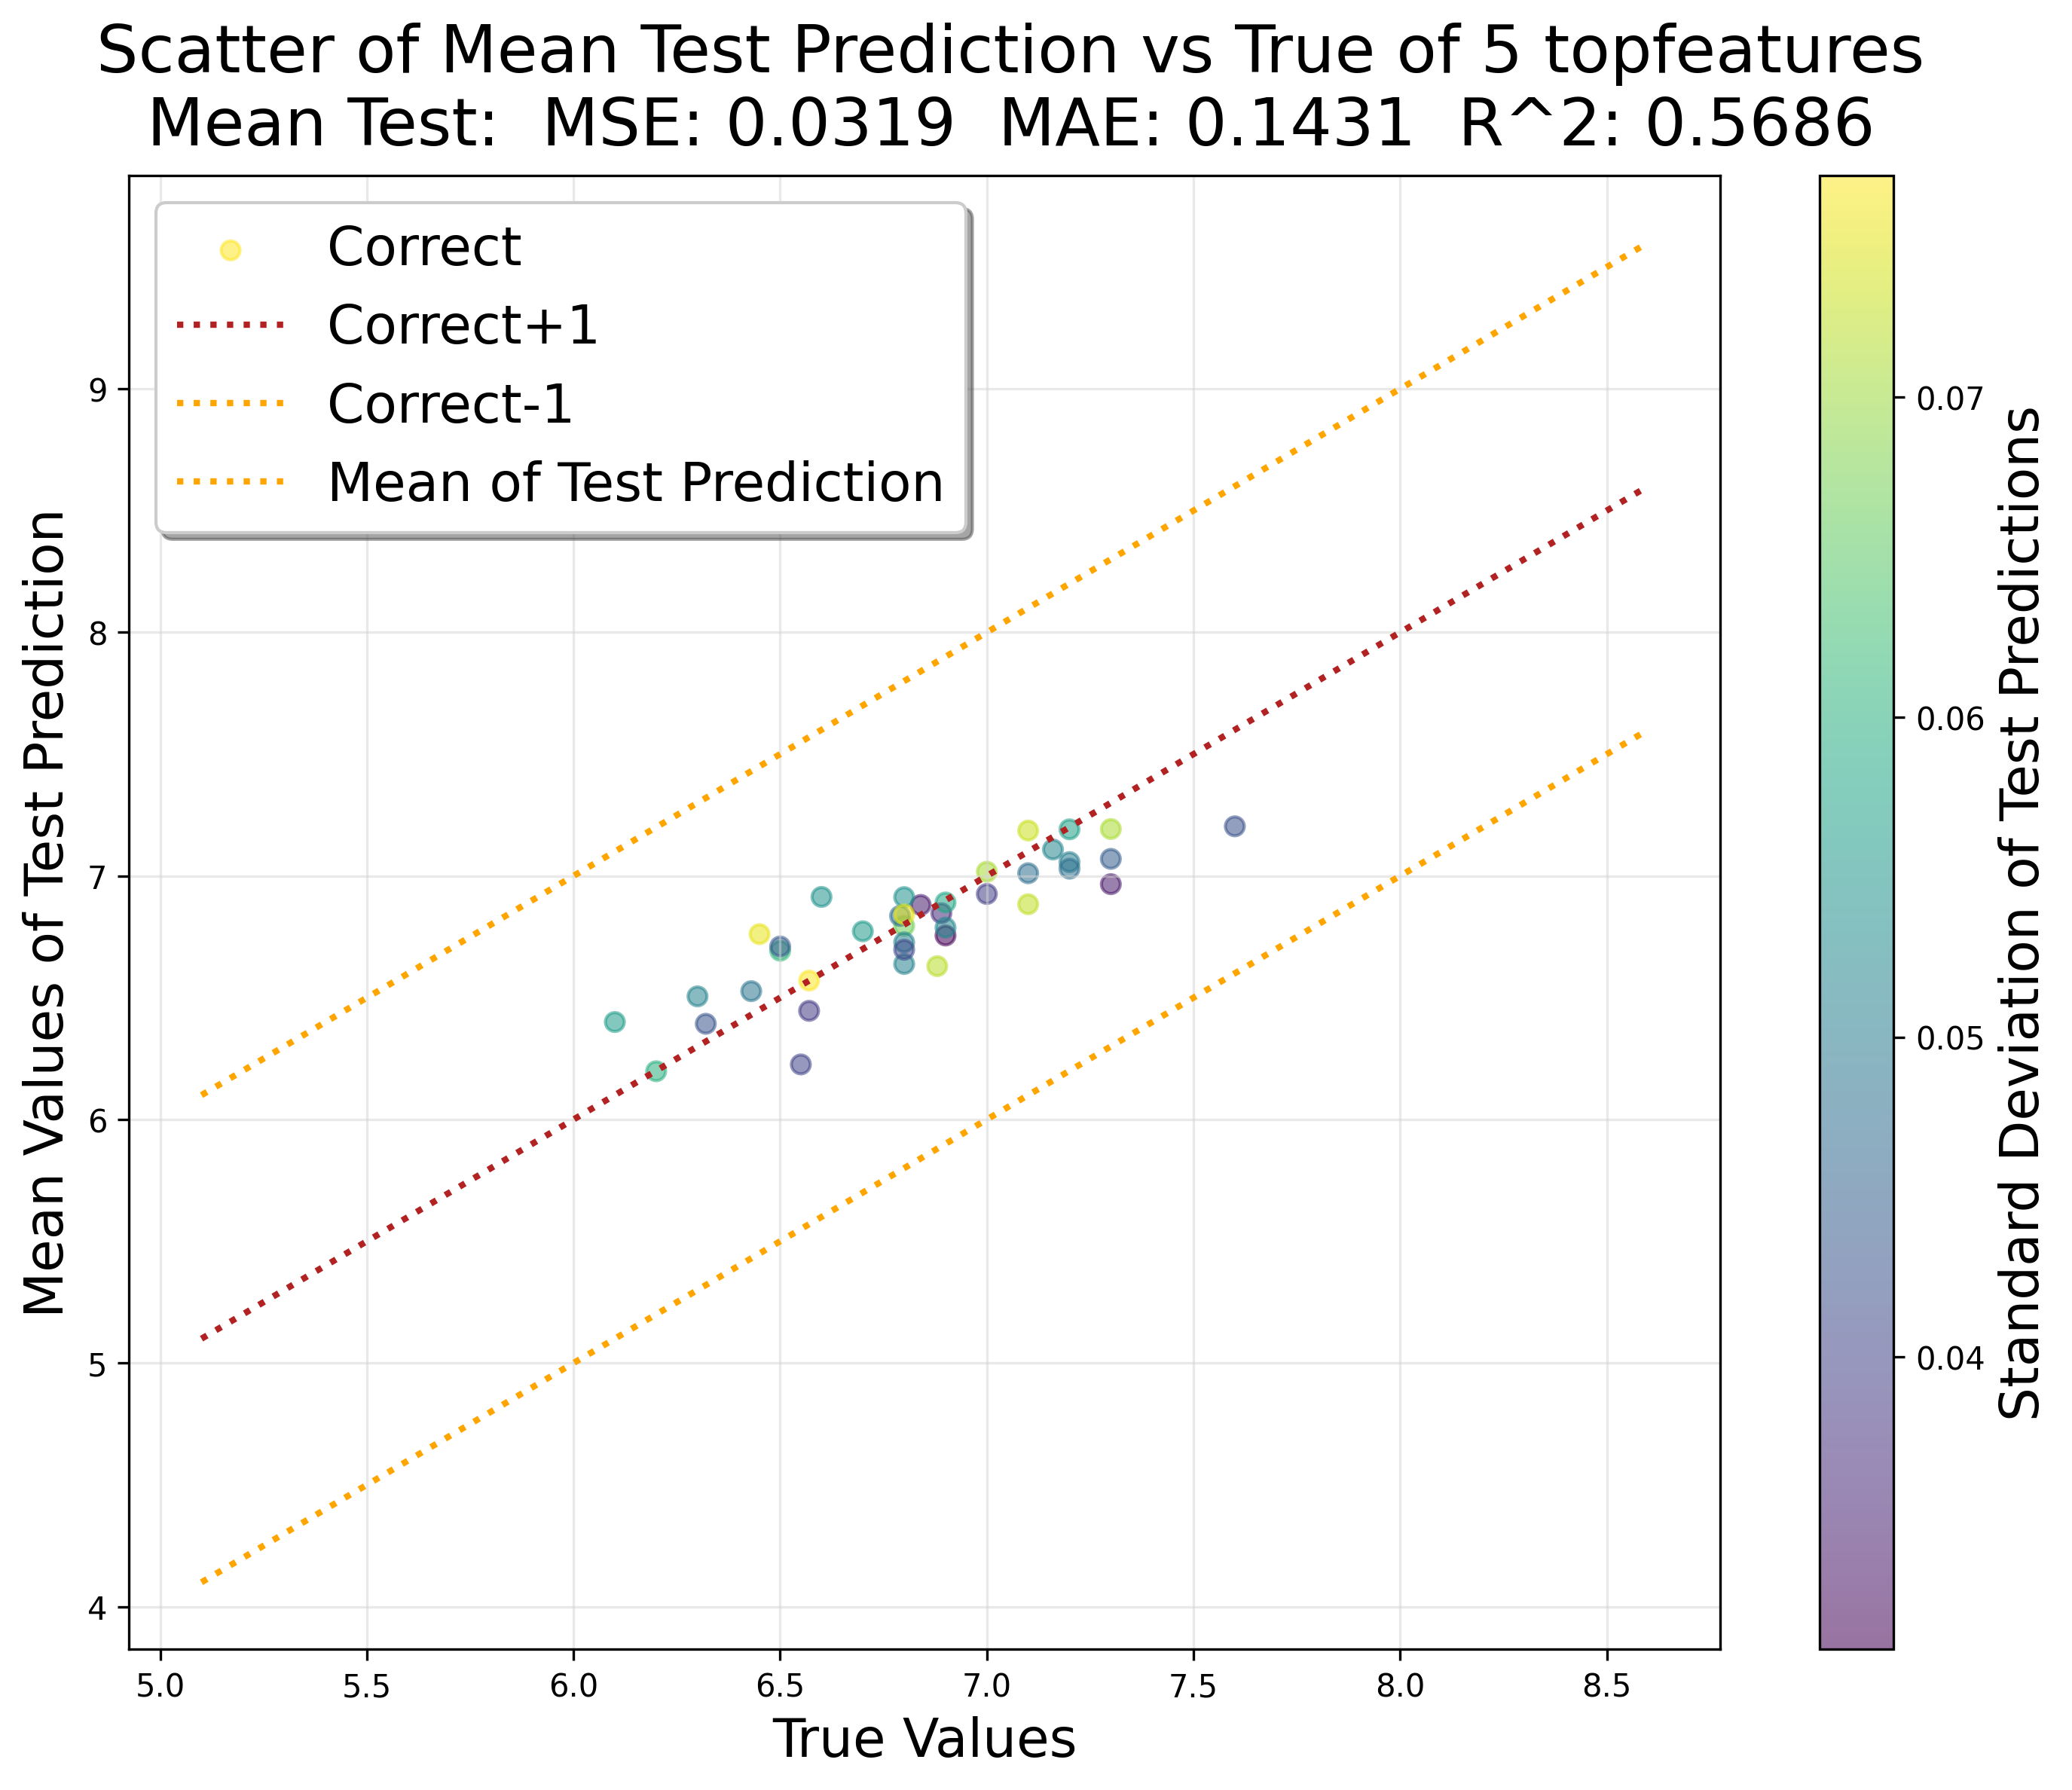

In [17]:
X = np.loadtxt(INPUT_X, delimiter=',')
y = np.loadtxt(INPUT_Y)
X_train = X[~test_mask]
y_train = y[~test_mask]
Xrealtest = X[test_mask]
yrealtest = y[test_mask]
X=X_train
y=y_train
print('X:', X.shape, '   y:', y.shape)
besttitle =title[bestfeatlist]
thistitleindex=[]
titlelist=[]
mselist=[]
Xtemp=[]
y_realtest_pred_list=[[]]

for jj in range(len(besttitle)):#len(title)-1
    
    thistitleindex=np.where(title==besttitle[jj])
    titlelist.append(thistitleindex[0][0])
    print(titlelist)
    Xtemp=X[:,titlelist]
    Xrealtesttemp=Xrealtest[:,titlelist]
    print(len(Xtemp[0]))
        
    perf=poolfit(TRAIN_TEST_SPLIT,EPOCH,CORE_NUM,Xtemp, y, paras,Xrealtesttemp)
    y_realtest_pred=perf[7]
    y_realtest_pred_reshaped = y_realtest_pred.reshape(1, -1)
    append_filename = Path('.', DIR, 'All_Realtestpred_' + c_time + '.txt')
    with open(append_filename, 'a+') as f:
        np.savetxt(f, y_realtest_pred_reshaped, fmt='%s', delimiter=',')
    
    
    y_realtest_pred_std=perf[8]
    y_realtest_pred_reshaped_std = y_realtest_pred_std.reshape(1, -1)
    append_filename = Path('.', DIR, 'All_Realtestpredstd_' + c_time + '.txt')
    with open(append_filename, 'a+') as f:
        np.savetxt(f, y_realtest_pred_reshaped_std, fmt='%s', delimiter=',')
    
        
    full_m=perf[3]
    full_m = np.array(full_m)
    test_idx_m = perf[4]
    test_idx_m = np.array(test_idx_m)
    save_name = 'XGBoost_02a_Test_Index_'+str(len(Xtemp[0]))+'_'+c_time+'.csv'
    save_name = Path('.', DIR, save_name)
    np.savetxt(save_name, test_idx_m, fmt='%d', delimiter=',')
    shap_m=perf[6]
    save_name = 'SHAP_Matrix_'+str(len(titlelist))+'_'+c_time+'.csv'
    save_name = Path('.', DIR, save_name)
    np.savetxt(save_name, shap_m, fmt='%s', delimiter=',')
    save_nameX = 'Feature_Matrix_'+str(len(titlelist))+'_'+c_time+'.csv'
    save_nameX = Path('.', DIR, save_nameX)
    np.savetxt(save_nameX, Xtemp, fmt='%s', delimiter=',')
    test_data_m = []
    for i in range(X.shape[0]):
        test_data_m.append([])
    for i in range(test_idx_m.shape[0]):
        for j in range(test_idx_m.shape[1]):
            test_data_m[test_idx_m[i, j]].append(full_m[i, test_idx_m[i, j]])
    test_upper_l = []
    test_lower_l = []
    test_mean_l = []
    test_median_l = []
    test_std_l = []
    for i in range(X.shape[0]):
        test_upper_l.append(max(test_data_m[i]))
        test_lower_l.append(min(test_data_m[i]))
        test_mean_l.append(np.mean(test_data_m[i]))
        test_median_l.append(np.median(test_data_m[i]))
        test_std_l.append(np.std(test_data_m[i]))
        
    true_y = y.flatten().tolist()
    fig = plt.figure(figsize=(10, 8), dpi=300)
    ax = fig.add_axes([0.11, 0.08, 0.88, 0.815])
    sc = ax.scatter(true_y, test_mean_l, alpha=0.55, c=test_std_l, cmap='viridis', marker='o')
    left_limit = min(min(true_y)-1, min(test_mean_l)-1)
    right_limit = max(max(true_y)+1, max(test_mean_l)+1)
    ax.plot([left_limit, right_limit], [left_limit, right_limit], color='#B22222', linestyle=':', linewidth = '2')
    ax.plot([left_limit, right_limit], [left_limit+1, right_limit+1], color='#FFA500', linestyle=':', linewidth = '2')
    ax.plot([left_limit, right_limit], [left_limit-1, right_limit-1], color='#FFA500', linestyle=':', linewidth = '2')
    ax.legend(['Correct', 'Correct+1', 'Correct-1', 'Mean of Test Prediction'], loc='upper left', fontsize=17, shadow=True)
    ax.set_xlabel('True Values', fontsize=17)
    ax.set_ylabel('Mean Values of Test Prediction', fontsize=17)
    plt.suptitle('Scatter of Mean Test Prediction vs True of '+str(len(Xtemp[0]))+' topfeatures\n'+
                 'Mean Test:  MSE: '+str(round(perf[0], 4))+
                 '  MAE: '+str(round(perf[1], 4))+
                 '  R^2: '+str(round(perf[2], 4)), fontsize=21)
    cb = plt.colorbar(sc)
    cb.set_label('Standard Deviation of Test Predictions', fontsize=17)
    plt.grid(which='major', color='#D5D5D5', alpha=0.5)
    save_name = 'XGBoost_02b_Mean_Test_Prediction_Distribution_'+str(len(Xtemp[0]))+'_'+c_time+'.png'
    save_name = Path('.', DIR, save_name)
    plt.savefig(save_name)
    plt.show()
    mselist.append(round(perf[0],3))
    xgbscatterdata= np.column_stack((true_y, test_mean_l, test_std_l))
    save_name1 = 'XGBoost_02c_Mean_Test_Prediction_Distribution_'+str(len(Xtemp[0]))+'_topfeatures'+'_MSE'+str(round(perf[0],3))+'_MSEstd'+str(round(perf[5],3))+'_MAE'+str(round(perf[1],3))+'_R^sq'+str(round(perf[2],3))+besttitle[jj]+'.txt'
    save_name2 = Path('.', DIR, save_name1)
    with open(save_name2,"w") as f:
        np.savetxt(save_name2,xgbscatterdata, fmt='%s', delimiter=',', comments='!')
    f.close()


In [18]:
len(Xtemp)

39

[0.064, 0.043, 0.04, 0.037, 0.032]
4
['buriedH5' 'N27aliemin' 'N1espmin' 'buriedH6' 'Asymmetry_Ratio']
[4]
[4, 40]
[4, 40, 20]
[4, 40, 20, 5]
[4, 40, 20, 5, 49]


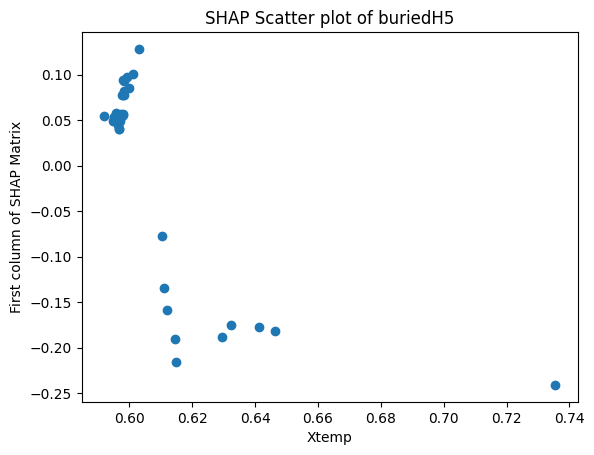

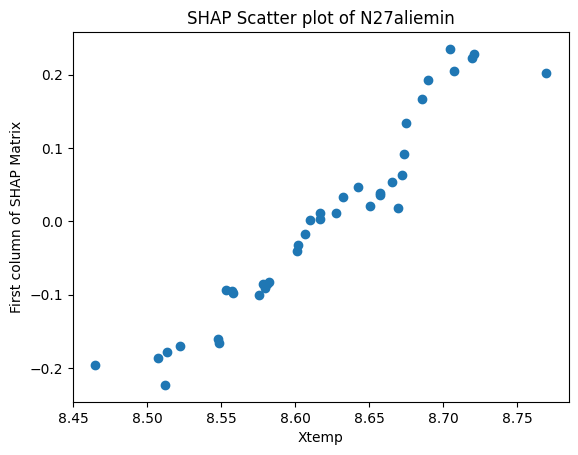

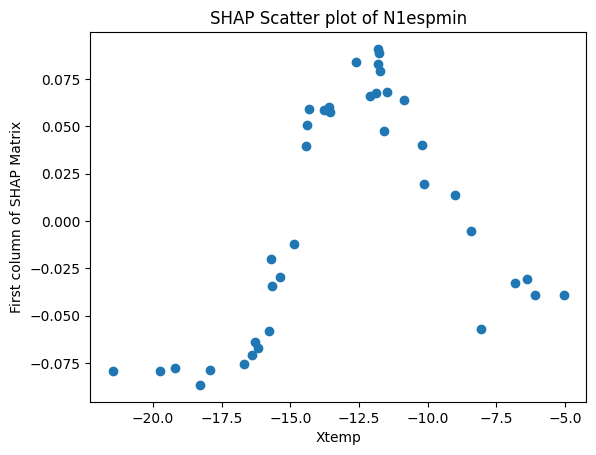

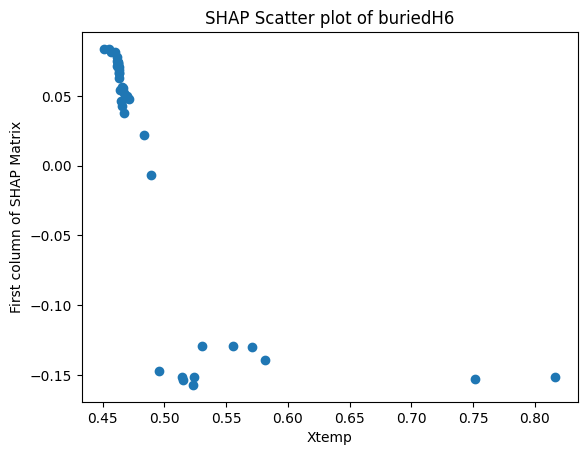

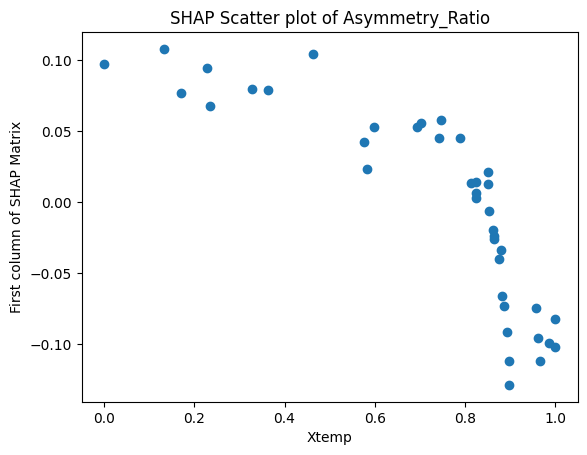

In [19]:
print(mselist)
print(mselist.index(min(mselist)))
print(title[bestfeatlist])
titlelist=[]
Xtemp=[]
for jj in range(len(bestfeatlist)):#len(title)-1
    thistitleindex=np.where(title==besttitle[jj])
    titlelist.append(thistitleindex[0][0])
    print(titlelist)
    Xtemp=X[:,titlelist]
# Create a scatter plot
for jj in range(len(bestfeatlist)):#len(title)-1
    plt.scatter(Xtemp[:,jj], shap_m[:, jj])
    plt.xlabel('Xtemp')
    plt.ylabel('First column of SHAP Matrix')
    plt.title('SHAP Scatter plot of '+title[titlelist[jj]])
    save_name = 'XGBoost_02b_Mean_Test_Prediction_Distribution_'+str(title[titlelist[jj]])+'_'+c_time+'.png'
    save_name = Path('.', DIR, save_name)
    plt.savefig(save_name)
    plt.show()

In [20]:
# 全特征的预测
point = round(X.shape[0]*TRAIN_TEST_SPLIT)
# featnum=mselist.index(min(mselist))
permutation = np.random.permutation(y.shape[0])
train_idx = permutation[:point]
test_idx = permutation[point:]
X_train = X[train_idx, :]
y_train = y[train_idx]
X_test = X[test_idx, :]
y_test = y[test_idx]

# 初始化XGBRegressor对象

clf = XGBRegressor(n_estimators=350, learning_rate=0.03, max_depth=8, verbosity=0, booster='gbtree', 
                   reg_alpha=np.exp(-3), reg_lambda=np.exp(-3), gamma=np.exp(-5), 
                   subsample=0.5, objective= 'reg:squarederror', n_jobs=1)
# 设置模型的超参数
for k, v in paras.items():
    clf.set_params(**{k: v})
clf.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=150, verbose=False)
# 计算在测试集上的预测值
y_pred = clf.predict(Xrealtest)
print(y_pred)
# titlelist=[]
# Xtemp=[]
# thistitleindex=[]
# Xrealtesttemp=[]
# for jj in range(len(besttitle)):#len(title)-1
#     thistitleindex=np.where(title==besttitle[jj])
#     titlelist.append(thistitleindex[0][0])
# #     print(titlelist)
#     Xtemp=X[:,titlelist]
#     Xrealtesttemp=Xrealtest[:,titlelist]
# clf.fit(Xtemp, y)
# # 计算损失
# y_pred2 = clf.predict(Xrealtesttemp)
# print(y_pred2)
save_name1 = 'XGBpred_Full'+'.txt'
save_name2 = Path('.', DIR, save_name1)
with open(save_name2,"w") as f:
    np.savetxt(save_name2,[y_pred,y_realtest_pred_reshaped[-1]], fmt='%s', delimiter=',', comments='!')


[6.500948  6.764545  6.8675413 7.088458 ]


In [21]:
mae = mean_absolute_error(yrealtest, y_realtest_pred_reshaped[-1])
mae

0.1431639099121096

In [22]:
len(X)

39